# Introdução à Ciência de Dados - Projeto Parte 2

<p align="justify">
Nessa etapa, iremos escolher uma das colunas do nosso dataset para para fazermos uma regressão baseada nas demais features. Avaliaremos quatro diferentes algoritmos para essa tarefa e utilizaremos o MLFlow para fazer o rastreamento. Adicionalmente, usaremos o Optuna para variar os hiperparâmetros de cada abordagem e escolher o melhor deles.

### Equipe:
> Pedro Henrique Almeida Girão Peixinho (phagp)

> Victor Gabriel de Carvalho (vgc3)

### Tópicos Avançados em Gerenciamento de Dados e Informação IF697 - 2024.1 - Centro de Informáica UFPE

In [5]:
import pandas as pd
import numpy as np

from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import logging
import mlflow
import optuna
# import autosklearn.regression

tf.random.set_seed(9)
keras.utils.set_random_seed(9)

In [2]:
df_cars = pd.read_csv('carscraper\cars.csv')
df_cars.head()

,page,car_brand,car_name,car_price,car_km,car_year,car_desc,car_store,car_engine,car_gearbox,car_fuel,car_color
0,https://grupoautonunes.com/estoque/?zero_km=0&...,Fiat,500E,125990.0,7521.0,2022,ICON ELÉTRICO,NaN,Elétrico,Automatico,Elétrico,NaN
1,https://grupoautonunes.com/estoque/?zero_km=0&...,Audi,Q3,128980.0,40000.0,2018,1.4 TFSI AMBIENTE FLEX 4P S TRONIC,NaN,1.4,Automatico,Flex,NaN
2,https://grupoautonunes.com/estoque/?zero_km=0&...,Chevrolet,Onix,70990.0,40686.0,2023,1.0 FLEX LT MANUAL,NaN,1.0,Manual,Flex,NaN
3,https://grupoautonunes.com/estoque/?zero_km=0&...,Chevrolet,Onix,79990.0,57643.0,2022,1.0 TURBO FLEX PLUS LTZ AUTOMÁTICO,NaN,1.0 Turbo,Automatico,Flex,NaN
4,https://grupoautonunes.com/estoque/?zero_km=0&...,Volkswagen,Saveiro,77990.0,29000.0,2023,1.6 MSI TRENDLINE CS 8V FLEX 2P MANUAL,NaN,1.6,Manual,Flex,NaN


In [3]:
df_cars.shape

(1124, 12)

In [4]:
df_cars.drop(['page', 'car_desc'], axis=1, inplace=True)
df_cars.drop_duplicates(inplace=True)

df_cars.head()

,car_brand,car_name,car_price,car_km,car_year,car_store,car_engine,car_gearbox,car_fuel,car_color
0,Fiat,500E,125990.0,7521.0,2022,NaN,Elétrico,Automatico,Elétrico,NaN
1,Audi,Q3,128980.0,40000.0,2018,NaN,1.4,Automatico,Flex,NaN
2,Chevrolet,Onix,70990.0,40686.0,2023,NaN,1.0,Manual,Flex,NaN
3,Chevrolet,Onix,79990.0,57643.0,2022,NaN,1.0 Turbo,Automatico,Flex,NaN
4,Volkswagen,Saveiro,77990.0,29000.0,2023,NaN,1.6,Manual,Flex,NaN


In [5]:
df_cars.dtypes

car_brand       object
car_name        object
car_price      float64
car_km         float64
car_year         int64
car_store       object
car_engine      object
car_gearbox     object
car_fuel        object
car_color       object
dtype: object

In [6]:
df_cars_cat = df_cars.copy()
object_columns = df_cars.select_dtypes(['object']).columns
df_cars_cat[object_columns] = df_cars[object_columns].astype('category')

df_cars_cat.dtypes

car_brand      category
car_name       category
car_price       float64
car_km          float64
car_year          int64
car_store      category
car_engine     category
car_gearbox    category
car_fuel       category
car_color      category
dtype: object

In [7]:
df_cars_cat.isnull().sum()

car_brand         0
car_name          0
car_price         0
car_km            0
car_year          0
car_store      1095
car_engine        0
car_gearbox       0
car_fuel         48
car_color       986
dtype: int64

In [8]:
df_cars_cat.dropna(thresh=0.7*len(df_cars_cat), axis=1, inplace=True)
df_cars_cat.count()

car_brand      1103
car_name       1103
car_price      1103
car_km         1103
car_year       1103
car_engine     1103
car_gearbox    1103
car_fuel       1055
dtype: int64

In [9]:
df_cars_codes = df_cars_cat.copy()
category_columns = df_cars_cat.select_dtypes(['category']).columns
df_cars_codes[category_columns] = df_cars_cat[category_columns].apply(lambda x: x.cat.codes.replace(-1, np.nan))

df_cars_codes.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,8,9,125990.0,7521.0,2022,29,0,1.0
1,1,108,128980.0,40000.0,2018,6,0,2.0
2,6,96,70990.0,40686.0,2023,0,1,2.0
3,6,96,79990.0,57643.0,2022,1,0,2.0
4,29,122,77990.0,29000.0,2023,10,1,2.0


---

In [10]:
# imputer = KNNImputer(n_neighbors=5)
# knn_fill = imputer.fit_transform(df_cars_codes)
# df_knn_fill = pd.DataFrame(data=knn_fill, columns=[df_cars_codes.columns])

# df_knn_fill.head()

In [11]:
# df_knn_fill_ee = df_knn_fill.copy()

# detector = EllipticEnvelope(contamination=0.01, support_fraction=0.85)
# detector.fit(df_knn_fill_ee)

In [12]:
# scores = detector.predict(df_knn_fill_ee)
# df_knn_fill_ee['outlier'] = scores

# df_knn_fill_ee.head()

In [13]:
# df_knn_fill_ee = df_knn_fill_ee[df_knn_fill_ee['outlier'] != -1]
# df_knn_fill_ee.head()

---

In [14]:
df_median_fill = df_cars_codes.copy()

df_median_fill['car_fuel'] = df_median_fill['car_fuel'].fillna(df_median_fill['car_fuel'].median())
df_median_fill.isnull().sum()

car_brand      0
car_name       0
car_price      0
car_km         0
car_year       0
car_engine     0
car_gearbox    0
car_fuel       0
dtype: int64

In [15]:
df_median_fill_ee = df_median_fill.copy()

detector = EllipticEnvelope(contamination=0.01, support_fraction=0.85)
detector.fit(df_median_fill_ee)

scores = detector.predict(df_median_fill_ee)
df_median_fill_ee['outlier'] = scores

df_median_fill_ee['outlier'] = df_median_fill_ee['outlier'].astype('int')

df_median_fill_ee.head()

df_median_fill_ee = df_median_fill_ee[df_median_fill_ee['outlier'] != -1]
df_median_fill_ee.drop('outlier', axis=1, inplace=True)
df_median_fill_ee.count()

car_brand      1091
car_name       1091
car_price      1091
car_km         1091
car_year       1091
car_engine     1091
car_gearbox    1091
car_fuel       1091
dtype: int64

In [16]:
min_max_scaler = MinMaxScaler()
df_knn_fill_norm = min_max_scaler.fit_transform(df_median_fill_ee)
df_knn_fill_norm = pd.DataFrame(df_knn_fill_norm, columns=df_median_fill_ee.columns)
df_knn_fill_norm.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,0.266667,0.057325,0.175680,0.011500,0.88,1.000000,0.0,0.2
1,0.033333,0.687898,0.180880,0.061162,0.72,0.206897,0.0,0.4
2,0.200000,0.611465,0.080013,0.062211,0.92,0.000000,1.0,0.4
3,0.200000,0.611465,0.095667,0.088139,0.88,0.034483,0.0,0.4
4,0.966667,0.777070,0.092188,0.044343,0.92,0.344828,1.0,0.4


---

## Modelos de Inferência 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_knn_fill_norm.drop('car_price', axis=1), df_knn_fill_norm['car_price'], test_size=0.2, random_state=9)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=9)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(872, 7) (110, 7) (109, 7)
(872,) (110,) (109,)


---

### Linear Regression

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_val, y_val)

0.5063485534942351

In [19]:
lin_reg_pred = lin_reg.predict(X_test)

---

### Random Forest Regressor

In [20]:
rf_reg = RandomForestRegressor(
    n_estimators=100, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
    random_state=9
)
rf_reg.fit(X_train, y_train)
rf_reg.score(X_val, y_val)

0.6994450151691001

In [21]:
rf_reg_pred = rf_reg.predict(X_test)

In [22]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 500)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
    # max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    rf_reg_obj = RandomForestRegressor(
        n_estimators=n_estimators, criterion=criterion, max_depth=None, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
        random_state=9
    )
    
    rf_reg_obj.fit(X_train, y_train)
    return rf_reg_obj.score(X_val, y_val)

In [23]:
study = optuna.create_study( study_name="Study for random forest regressor", direction="maximize")
study.optimize(objective_rf, n_trials=100)
print(study.best_trial)

[I 2024-07-08 19:06:22,690] A new study created in memory with name: no-name-4138bb73-f492-4aae-9990-1eee0470675d
[I 2024-07-08 19:06:25,293] Trial 0 finished with value: 0.7493819012625473 and parameters: {'n_estimators': 231, 'criterion': 'absolute_error', 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7493819012625473.
[I 2024-07-08 19:06:25,522] Trial 1 finished with value: 0.713823300732352 and parameters: {'n_estimators': 114, 'criterion': 'poisson', 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7493819012625473.
[I 2024-07-08 19:06:25,589] Trial 2 finished with value: 0.724903674833149 and parameters: {'n_estimators': 38, 'criterion': 'squared_error', 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7493819012625473.
[I 2024-07-08 19:06:30,008] Trial 3 finished with value: 0.753809083558227 and parameters: {'n_estimators': 394, 'criterion': 'absolute_error', 'min_samples_split': 3, 'min_s

FrozenTrial(number=54, state=1, values=[0.760049128930771], datetime_start=datetime.datetime(2024, 7, 8, 19, 8, 9, 193141), datetime_complete=datetime.datetime(2024, 7, 8, 19, 8, 11, 207950), params={'n_estimators': 178, 'criterion': 'absolute_error', 'min_samples_split': 10, 'min_samples_leaf': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=20, step=1), 'criterion': CategoricalDistribution(choices=('squared_error', 'absolute_error', 'friedman_mse', 'poisson')), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=54, value=None)


---

### Gradient Boosting Regressor

In [24]:
gb_reg = GradientBoostingRegressor(
    loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse',
    random_state=9
)
gb_reg.fit(X_train, y_train)
gb_reg.score(X_val, y_val)

0.8066778883652442

In [25]:
gb_reg_pred = gb_reg.predict(X_test)

In [26]:
def objective_gb(trial):
    loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.5)
    n_estimators = trial.suggest_int('n_estimators', 20, 500)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    
    gb_reg_obj = GradientBoostingRegressor(
        loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, criterion=criterion, 
        random_state=9
    )
    
    gb_reg_obj.fit(X_train, y_train)
    return gb_reg_obj.score(X_val, y_val)

In [27]:
study = optuna.create_study( study_name="Study for gradient boosting regressor", direction="maximize")
study.optimize(objective_gb, n_trials=100)
print(study.best_trial)

[I 2024-07-08 19:14:33,366] A new study created in memory with name: Study for random forest regressor
[I 2024-07-08 19:14:33,394] Trial 0 finished with value: 0.7378626733141852 and parameters: {'loss': 'squared_error', 'learning_rate': 0.2404454584280185, 'n_estimators': 23, 'subsample': 0.8770862072516894, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.7378626733141852.
[I 2024-07-08 19:14:33,678] Trial 1 finished with value: 0.6101185380587102 and parameters: {'loss': 'quantile', 'learning_rate': 0.1376726933253858, 'n_estimators': 181, 'subsample': 0.22850681791143862, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.7378626733141852.
[I 2024-07-08 19:14:33,954] Trial 2 finished with value: 0.634551355643088 and parameters: {'loss': 'quantile', 'learning_rate': 0.16098611974021887, 'n_estimators': 138, 'subsample': 0.7373941321490426, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.7378626733141852.
[I 2024-07-08 19:14:34,049] Trial 3 finished 

FrozenTrial(number=39, state=1, values=[0.9159386712564102], datetime_start=datetime.datetime(2024, 7, 8, 19, 14, 56, 197471), datetime_complete=datetime.datetime(2024, 7, 8, 19, 14, 56, 999038), params={'loss': 'huber', 'learning_rate': 0.2598882776892324, 'n_estimators': 299, 'subsample': 0.8485702363476764, 'criterion': 'squared_error'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'loss': CategoricalDistribution(choices=('squared_error', 'absolute_error', 'huber', 'quantile')), 'learning_rate': FloatDistribution(high=0.5, log=False, low=0.05, step=None), 'n_estimators': IntDistribution(high=500, log=False, low=20, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'criterion': CategoricalDistribution(choices=('friedman_mse', 'squared_error'))}, trial_id=39, value=None)


---

### Artificial Neural Network

In [28]:
nn_reg = tf.keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam(0.001)
nn_reg.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'r2_score'])

nn_reg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

nn_reg.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0264 - mae: 0.0882 - r2_score: -0.0590 - val_loss: 0.0124 - val_mae: 0.0619 - val_r2_score: 0.3162
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - mae: 0.0682 - r2_score: 0.3256 - val_loss: 0.0116 - val_mae: 0.0550 - val_r2_score: 0.3583
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - mae: 0.0631 - r2_score: 0.3525 - val_loss: 0.0112 - val_mae: 0.0542 - val_r2_score: 0.3805
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - mae: 0.0625 - r2_score: 0.3766 - val_loss: 0.0107 - val_mae: 0.0532 - val_r2_score: 0.4088
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0614 - r2_score: 0.3965 - val_loss: 0.0101 - val_mae: 0.0520 - val_r2_score: 0.4420
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0605 - r2_score: 0.4183 - val_loss: 0.0097 - val_mae: 0.0515 - val_r2_score: 0.4662
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

In [30]:
nn_reg.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - mae: 0.0361 - r2_score: 0.8046 


[0.004316628444939852, 0.03915241360664368, 0.7429929971694946]

In [31]:
nn_reg_pred = nn_reg.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [32]:
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    
    model = tf.keras.Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],)))
    
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_{i}', 4, 128)
        activation = trial.suggest_categorical(f'activation_{i}', ['relu', 'tanh', 'sigmoid', 'linear'])
        
        model.add(
            layers.Dense(
                n_units, activation=activation, kernel_regularizer=keras.regularizers.l2(weight_decay)
            )
        )
    
    model.add(layers.Dense(1))
    
    return model

def create_optimizer(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer = tf.keras.optimizers.Adam(lr)
    
    return optimizer

In [33]:
def objective_nn(trial):
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'r2_score'])
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop])
    
    return model.evaluate(X_test, y_test)[2]

In [34]:
study = optuna.create_study( study_name="Study for neural network regressor", direction="maximize")
study.optimize(objective_nn, n_trials=100)
print(study.best_trial)

[I 2024-07-08 19:24:12,678] A new study created in memory with name: Study for neural network regressor


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1396 - mae: 0.2742 - r2_score: -4.2606 - val_loss: 0.0119 - val_mae: 0.0741 - val_r2_score: 0.3745
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mae: 0.0794 - r2_score: 0.3579 - val_loss: 0.0096 - val_mae: 0.0639 - val_r2_score: 0.5041
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - mae: 0.0679 - r2_score: 0.4693 - val_loss: 0.0073 - val_mae: 0.0535 - val_r2_score: 0.6297
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - mae: 0.0635 - r2_score: 0.5368 - val_loss: 0.0073 - val_mae: 0.0484 - val_r2_score: 0.6323
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mae: 0.0561 - r2_score: 0.5870 - val_loss: 0.0079 - val_mae: 0.0512 - val_r2_score: 0.5962
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - mae: 0.0528 - r2_score: 0.6092 - val_loss: 0.0083 - val_mae: 0.0579 - val_r2_score: 0.5745
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:24:15,522] Trial 0 finished with value: 0.6733846664428711 and parameters: {'n_layers': 2, 'weight_decay': 5.364902914917377e-06, 'n_units_0': 107, 'activation_0': 'linear', 'n_units_1': 91, 'activation_1': 'relu', 'lr': 0.007212769100980987}. Best is trial 0 with value: 0.6733846664428711.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0315 - mae: 0.1116 - r2_score: -0.2370 - val_loss: 0.0097 - val_mae: 0.0516 - val_r2_score: 0.4636
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - mae: 0.0641 - r2_score: 0.3899 - val_loss: 0.0076 - val_mae: 0.0491 - val_r2_score: 0.5805
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128 - mae: 0.0594 - r2_score: 0.4785 - val_loss: 0.0062 - val_mae: 0.0457 - val_r2_score: 0.6609
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - mae: 0.0574 - r2_score: 0.5412 - val_loss: 0.0055 - val_mae: 0.0445 - val_r2_score: 0.6989
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - mae: 0.0538 - r2_score: 0.5985 - val_loss: 0.0050 - val_mae: 0.0386 - val_r2_score: 0.7236
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - mae: 0.0501 - r2_score: 0.6399 - val_loss: 0.0050 - val_mae: 0.0393 - val_r2_score: 0.7227
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:24:19,858] Trial 1 finished with value: 0.7241482734680176 and parameters: {'n_layers': 3, 'weight_decay': 8.874746606243791e-09, 'n_units_0': 47, 'activation_0': 'relu', 'n_units_1': 107, 'activation_1': 'tanh', 'n_units_2': 116, 'activation_2': 'relu', 'lr': 0.001000646010091206}. Best is trial 1 with value: 0.7241482734680176.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0321 - mae: 0.9614 - r2_score: -192.7738 - val_loss: 0.0215 - val_mae: 0.0948 - val_r2_score: -0.1865
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224 - mae: 0.0915 - r2_score: 0.0829 - val_loss: 0.0127 - val_mae: 0.0630 - val_r2_score: 0.3004
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - mae: 0.0789 - r2_score: 0.2510 - val_loss: 0.0110 - val_mae: 0.0727 - val_r2_score: 0.3929
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - mae: 0.0802 - r2_score: 0.3211 - val_loss: 0.0096 - val_mae: 0.0566 - val_r2_score: 0.4707
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - mae: 0.0776 - r2_score: 0.3317 - val_loss: 0.0092 - val_mae: 0.0540 - val_r2_score: 0.4913
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0702 - r2_score: 0.4073 - val_loss: 0.0102 - val_mae: 0.0596 - val_r2_score: 0.4377
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2024-07-08 19:24:23,222] Trial 2 finished with value: 0.6458374261856079 and parameters: {'n_layers': 3, 'weight_decay': 1.7043973211616367e-08, 'n_units_0': 92, 'activation_0': 'tanh', 'n_units_1': 113, 'activation_1': 'relu', 'n_units_2': 97, 'activation_2': 'relu', 'lr': 0.03918813924206094}. Best is trial 1 with value: 0.7241482734680176.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0924 - mae: 0.2471 - r2_score: -2.7423 - val_loss: 0.0162 - val_mae: 0.0757 - val_r2_score: 0.1069
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220 - mae: 0.0868 - r2_score: 0.0913 - val_loss: 0.0136 - val_mae: 0.0692 - val_r2_score: 0.2523
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - mae: 0.0757 - r2_score: 0.2234 - val_loss: 0.0129 - val_mae: 0.0641 - val_r2_score: 0.2901
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mae: 0.0735 - r2_score: 0.2584 - val_loss: 0.0124 - val_mae: 0.0617 - val_r2_score: 0.3155
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - mae: 0.0707 - r2_score: 0.2826 - val_loss: 0.0122 - val_mae: 0.0600 - val_r2_score: 0.3284
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mae: 0.0688 - r2_score: 0.2986 - val_loss: 0.0120 - val_mae: 0.0590 - val_r2_score: 0.3409
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:24:31,148] Trial 3 finished with value: 0.6955665349960327 and parameters: {'n_layers': 4, 'weight_decay': 9.89440723312529e-09, 'n_units_0': 84, 'activation_0': 'linear', 'n_units_1': 58, 'activation_1': 'relu', 'n_units_2': 56, 'activation_2': 'tanh', 'n_units_3': 85, 'activation_3': 'tanh', 'lr': 6.679362506051822e-05}. Best is trial 1 with value: 0.7241482734680176.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0296 - mae: 0.1106 - r2_score: -0.2210 - val_loss: 0.0138 - val_mae: 0.0704 - val_r2_score: 0.2391
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - mae: 0.0790 - r2_score: 0.2142 - val_loss: 0.0121 - val_mae: 0.0609 - val_r2_score: 0.3323
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mae: 0.0697 - r2_score: 0.3013 - val_loss: 0.0113 - val_mae: 0.0563 - val_r2_score: 0.3789
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0657 - r2_score: 0.3502 - val_loss: 0.0107 - val_mae: 0.0564 - val_r2_score: 0.4094
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - mae: 0.0647 - r2_score: 0.3813 - val_loss: 0.0104 - val_mae: 0.0567 - val_r2_score: 0.4274
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - mae: 0.0641 - r2_score: 0.4000 - val_loss: 0.0101 - val_mae: 0.0566 - val_r2_score: 0.4424
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:24:38,873] Trial 4 finished with value: 0.7468811273574829 and parameters: {'n_layers': 4, 'weight_decay': 4.4992824199845176e-08, 'n_units_0': 63, 'activation_0': 'relu', 'n_units_1': 108, 'activation_1': 'tanh', 'n_units_2': 123, 'activation_2': 'tanh', 'n_units_3': 32, 'activation_3': 'relu', 'lr': 5.456090516636959e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2470 - mae: 0.4055 - r2_score: -9.1496 - val_loss: 0.0254 - val_mae: 0.1178 - val_r2_score: -0.3646
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - mae: 0.1169 - r2_score: -0.1219 - val_loss: 0.0129 - val_mae: 0.0792 - val_r2_score: 0.3256
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mae: 0.0760 - r2_score: 0.3273 - val_loss: 0.0107 - val_mae: 0.0608 - val_r2_score: 0.4440
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mae: 0.0722 - r2_score: 0.3649 - val_loss: 0.0119 - val_mae: 0.0670 - val_r2_score: 0.3801
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mae: 0.0743 - r2_score: 0.3567 - val_loss: 0.0111 - val_mae: 0.0631 - val_r2_score: 0.4193
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mae: 0.0728 - r2_score: 0.3862 - val_loss: 0.0100 - val_mae: 0.0567 - val_r2_score: 0.4802
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:24:40,853] Trial 5 finished with value: 0.5243630409240723 and parameters: {'n_layers': 1, 'weight_decay': 2.7184587434175785e-05, 'n_units_0': 36, 'activation_0': 'sigmoid', 'lr': 0.04759373682157513}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0249 - mae: 0.0911 - r2_score: -0.0029 - val_loss: 0.0115 - val_mae: 0.0616 - val_r2_score: 0.3704
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mae: 0.0696 - r2_score: 0.3366 - val_loss: 0.0097 - val_mae: 0.0542 - val_r2_score: 0.4669
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - mae: 0.0647 - r2_score: 0.3978 - val_loss: 0.0091 - val_mae: 0.0529 - val_r2_score: 0.5000
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - mae: 0.0632 - r2_score: 0.4298 - val_loss: 0.0085 - val_mae: 0.0525 - val_r2_score: 0.5336
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - mae: 0.0618 - r2_score: 0.4616 - val_loss: 0.0080 - val_mae: 0.0523 - val_r2_score: 0.5578
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0126 - mae: 0.0609 - r2_score: 0.4862 - val_loss: 0.0077 - val_mae: 0.0514 - val_r2_score: 0.5797
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:24:46,921] Trial 6 finished with value: 0.6777102947235107 and parameters: {'n_layers': 3, 'weight_decay': 1.2581986380366828e-07, 'n_units_0': 81, 'activation_0': 'tanh', 'n_units_1': 94, 'activation_1': 'relu', 'n_units_2': 106, 'activation_2': 'linear', 'lr': 0.00019200154715967764}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2082 - mae: 1.3096 - r2_score: -130.9967 - val_loss: 0.2666 - val_mae: 0.5033 - val_r2_score: -13.6880
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1411 - mae: 0.3177 - r2_score: -4.6955 - val_loss: 0.0244 - val_mae: 0.1409 - val_r2_score: -0.3385
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255 - mae: 0.1219 - r2_score: -0.0597 - val_loss: 0.0135 - val_mae: 0.0652 - val_r2_score: 0.2620
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - mae: 0.0800 - r2_score: 0.2445 - val_loss: 0.0117 - val_mae: 0.0613 - val_r2_score: 0.3571
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mae: 0.0737 - r2_score: 0.3179 - val_loss: 0.0108 - val_mae: 0.0607 - val_r2_score: 0.4111
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mae: 0.0754 - r2_score: 0.3408 - val_loss: 0.0105 - val_mae: 0.0646 - val_r2_score: 0.4248
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━

[I 2024-07-08 19:24:50,104] Trial 7 finished with value: 0.5487043261528015 and parameters: {'n_layers': 1, 'weight_decay': 5.4403449168764175e-06, 'n_units_0': 102, 'activation_0': 'linear', 'lr': 0.08432081564040217}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0341 - mae: 0.1401 - r2_score: -0.4101 - val_loss: 0.0152 - val_mae: 0.0888 - val_r2_score: 0.1626
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - mae: 0.0881 - r2_score: 0.2775 - val_loss: 0.0112 - val_mae: 0.0629 - val_r2_score: 0.3836
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - mae: 0.0693 - r2_score: 0.3731 - val_loss: 0.0104 - val_mae: 0.0586 - val_r2_score: 0.4297
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0669 - r2_score: 0.3907 - val_loss: 0.0100 - val_mae: 0.0581 - val_r2_score: 0.4477
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - mae: 0.0662 - r2_score: 0.4051 - val_loss: 0.0098 - val_mae: 0.0578 - val_r2_score: 0.4611
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 - mae: 0.0660 - r2_score: 0.4157 - val_loss: 0.0096 - val_mae: 0.0576 - val_r2_score: 0.4699
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:24:52,828] Trial 8 finished with value: 0.5486207604408264 and parameters: {'n_layers': 1, 'weight_decay': 4.170039169870777e-10, 'n_units_0': 54, 'activation_0': 'linear', 'lr': 0.0008807966173732567}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0591 - mae: 0.1501 - r2_score: -0.8180 - val_loss: 0.0369 - val_mae: 0.0992 - val_r2_score: -0.1939
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0387 - mae: 0.0898 - r2_score: 0.0405 - val_loss: 0.0290 - val_mae: 0.0698 - val_r2_score: 0.2431
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0328 - mae: 0.0710 - r2_score: 0.2790 - val_loss: 0.0273 - val_mae: 0.0639 - val_r2_score: 0.3356
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314 - mae: 0.0682 - r2_score: 0.3346 - val_loss: 0.0268 - val_mae: 0.0625 - val_r2_score: 0.3621
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0309 - mae: 0.0674 - r2_score: 0.3572 - val_loss: 0.0267 - val_mae: 0.0621 - val_r2_score: 0.3675
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306 - mae: 0.0668 - r2_score: 0.3692 - val_loss: 0.0265 - val_mae: 0.0617 - val_r2_score: 0.3761
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:25:02,978] Trial 9 finished with value: 0.6119598150253296 and parameters: {'n_layers': 4, 'weight_decay': 9.606150784035684e-05, 'n_units_0': 22, 'activation_0': 'linear', 'n_units_1': 74, 'activation_1': 'linear', 'n_units_2': 126, 'activation_2': 'tanh', 'n_units_3': 12, 'activation_3': 'relu', 'lr': 4.716211423904552e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0890 - mae: 0.2864 - r2_score: -2.8365 - val_loss: 0.0593 - val_mae: 0.2303 - val_r2_score: -2.2682
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0608 - mae: 0.2323 - r2_score: -1.6105 - val_loss: 0.0394 - val_mae: 0.1833 - val_r2_score: -1.1686
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0426 - mae: 0.1873 - r2_score: -0.8207 - val_loss: 0.0277 - val_mae: 0.1461 - val_r2_score: -0.5266
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0322 - mae: 0.1518 - r2_score: -0.3653 - val_loss: 0.0217 - val_mae: 0.1185 - val_r2_score: -0.1932
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269 - mae: 0.1255 - r2_score: -0.1302 - val_loss: 0.0189 - val_mae: 0.1010 - val_r2_score: -0.0433
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0245 - mae: 0.1082 - r2_score: -0.0235 - val_loss: 0.0179 - val_mae: 0.0916 - val_r2_score: 0.0120
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━

[I 2024-07-08 19:25:05,938] Trial 10 finished with value: 0.029508590698242188 and parameters: {'n_layers': 5, 'weight_decay': 1.806253525189084e-10, 'n_units_0': 6, 'activation_0': 'relu', 'n_units_1': 9, 'activation_1': 'sigmoid', 'n_units_2': 5, 'activation_2': 'sigmoid', 'n_units_3': 28, 'activation_3': 'linear', 'n_units_4': 34, 'activation_4': 'linear', 'lr': 2.709819385553316e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0325 - mae: 0.1206 - r2_score: -0.2924 - val_loss: 0.0104 - val_mae: 0.0640 - val_r2_score: 0.4279
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0779 - r2_score: 0.3448 - val_loss: 0.0102 - val_mae: 0.0547 - val_r2_score: 0.4400
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - mae: 0.0656 - r2_score: 0.4121 - val_loss: 0.0089 - val_mae: 0.0516 - val_r2_score: 0.5113
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - mae: 0.0609 - r2_score: 0.4651 - val_loss: 0.0078 - val_mae: 0.0500 - val_r2_score: 0.5696
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - mae: 0.0592 - r2_score: 0.5147 - val_loss: 0.0070 - val_mae: 0.0491 - val_r2_score: 0.6165
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - mae: 0.0576 - r2_score: 0.5558 - val_loss: 0.0067 - val_mae: 0.0519 - val_r2_score: 0.6286
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:25:10,288] Trial 11 finished with value: 0.6760951280593872 and parameters: {'n_layers': 4, 'weight_decay': 5.719980721566166e-09, 'n_units_0': 59, 'activation_0': 'relu', 'n_units_1': 128, 'activation_1': 'tanh', 'n_units_2': 127, 'activation_2': 'relu', 'n_units_3': 56, 'activation_3': 'relu', 'lr': 0.000809181598357943}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1689 - mae: 0.3784 - r2_score: -6.1035 - val_loss: 0.0923 - val_mae: 0.2730 - val_r2_score: -4.0796
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0810 - mae: 0.2361 - r2_score: -2.3652 - val_loss: 0.0420 - val_mae: 0.1551 - val_r2_score: -1.3066
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0413 - mae: 0.1291 - r2_score: -0.6936 - val_loss: 0.0241 - val_mae: 0.0861 - val_r2_score: -0.3248
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - mae: 0.0790 - r2_score: -0.1496 - val_loss: 0.0193 - val_mae: 0.0753 - val_r2_score: -0.0574
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0247 - mae: 0.0760 - r2_score: -0.0143 - val_loss: 0.0182 - val_mae: 0.0770 - val_r2_score: 0.0050
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239 - mae: 0.0801 - r2_score: 0.0153 - val_loss: 0.0179 - val_mae: 0.0778 - val_r2_score: 0.0219
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━

[I 2024-07-08 19:25:20,936] Trial 12 finished with value: 0.26576441526412964 and parameters: {'n_layers': 5, 'weight_decay': 3.156557034388714e-07, 'n_units_0': 43, 'activation_0': 'relu', 'n_units_1': 48, 'activation_1': 'tanh', 'n_units_2': 78, 'activation_2': 'relu', 'n_units_3': 114, 'activation_3': 'sigmoid', 'n_units_4': 121, 'activation_4': 'relu', 'lr': 1.1957706136975004e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0450 - mae: 0.1527 - r2_score: -0.8050 - val_loss: 0.0112 - val_mae: 0.0589 - val_r2_score: 0.3847
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - mae: 0.0737 - r2_score: 0.3825 - val_loss: 0.0088 - val_mae: 0.0499 - val_r2_score: 0.5141
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - mae: 0.0644 - r2_score: 0.4609 - val_loss: 0.0076 - val_mae: 0.0467 - val_r2_score: 0.5830
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - mae: 0.0608 - r2_score: 0.5190 - val_loss: 0.0073 - val_mae: 0.0490 - val_r2_score: 0.5981
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - mae: 0.0587 - r2_score: 0.5549 - val_loss: 0.0067 - val_mae: 0.0444 - val_r2_score: 0.6319
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - mae: 0.0564 - r2_score: 0.5855 - val_loss: 0.0061 - val_mae: 0.0407 - val_r2_score: 0.6648
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:25:23,648] Trial 13 finished with value: 0.6850024461746216 and parameters: {'n_layers': 2, 'weight_decay': 1.706756499390841e-09, 'n_units_0': 70, 'activation_0': 'relu', 'n_units_1': 108, 'activation_1': 'tanh', 'lr': 0.0034626210390136048}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0832 - mae: 0.2111 - r2_score: -2.3411 - val_loss: 0.0172 - val_mae: 0.0834 - val_r2_score: 0.0510
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 - mae: 0.0843 - r2_score: 0.1494 - val_loss: 0.0120 - val_mae: 0.0681 - val_r2_score: 0.3374
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - mae: 0.0771 - r2_score: 0.3245 - val_loss: 0.0117 - val_mae: 0.0650 - val_r2_score: 0.3565
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0726 - r2_score: 0.3499 - val_loss: 0.0110 - val_mae: 0.0627 - val_r2_score: 0.3946
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - mae: 0.0708 - r2_score: 0.3721 - val_loss: 0.0106 - val_mae: 0.0612 - val_r2_score: 0.4180
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0691 - r2_score: 0.3915 - val_loss: 0.0102 - val_mae: 0.0595 - val_r2_score: 0.4401
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:25:33,637] Trial 14 finished with value: 0.6630979776382446 and parameters: {'n_layers': 3, 'weight_decay': 5.686705270976844e-08, 'n_units_0': 30, 'activation_0': 'relu', 'n_units_1': 126, 'activation_1': 'tanh', 'n_units_2': 56, 'activation_2': 'tanh', 'lr': 0.00025108570219987096}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4336 - mae: 0.4787 - r2_score: -14.9194 - val_loss: 0.0236 - val_mae: 0.1266 - val_r2_score: -0.2821
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - mae: 0.0970 - r2_score: -0.0323 - val_loss: 0.0193 - val_mae: 0.0777 - val_r2_score: -0.0462
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255 - mae: 0.0923 - r2_score: -0.0410 - val_loss: 0.0175 - val_mae: 0.0842 - val_r2_score: 0.0563
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244 - mae: 0.0920 - r2_score: -0.0025 - val_loss: 0.0172 - val_mae: 0.0920 - val_r2_score: 0.0708
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242 - mae: 0.0947 - r2_score: 0.0015 - val_loss: 0.0153 - val_mae: 0.0791 - val_r2_score: 0.1751
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 - mae: 0.0766 - r2_score: 0.1538 - val_loss: 0.0138 - val_mae: 0.0599 - val_r2_score: 0.2615
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-07-08 19:25:37,768] Trial 15 finished with value: 0.5446480512619019 and parameters: {'n_layers': 4, 'weight_decay': 1.353103421652988e-06, 'n_units_0': 124, 'activation_0': 'sigmoid', 'n_units_1': 81, 'activation_1': 'tanh', 'n_units_2': 102, 'activation_2': 'sigmoid', 'n_units_3': 51, 'activation_3': 'relu', 'lr': 0.0047086791783794895}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4225 - mae: 0.6270 - r2_score: -16.7547 - val_loss: 0.0705 - val_mae: 0.2552 - val_r2_score: -2.8839
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0488 - mae: 0.1931 - r2_score: -1.0088 - val_loss: 0.0169 - val_mae: 0.0741 - val_r2_score: 0.0667
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233 - mae: 0.0877 - r2_score: 0.0336 - val_loss: 0.0169 - val_mae: 0.0731 - val_r2_score: 0.0703
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - mae: 0.0855 - r2_score: 0.0585 - val_loss: 0.0162 - val_mae: 0.0727 - val_r2_score: 0.1101
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - mae: 0.0847 - r2_score: 0.0796 - val_loss: 0.0160 - val_mae: 0.0712 - val_r2_score: 0.1165
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - mae: 0.0830 - r2_score: 0.0897 - val_loss: 0.0158 - val_mae: 0.0703 - val_r2_score: 0.1277
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2024-07-08 19:25:47,121] Trial 16 finished with value: 0.6575221419334412 and parameters: {'n_layers': 2, 'weight_decay': 1.3923475851966752e-09, 'n_units_0': 51, 'activation_0': 'relu', 'n_units_1': 105, 'activation_1': 'sigmoid', 'lr': 0.00025063060584314806}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0834 - mae: 0.2389 - r2_score: -2.3337 - val_loss: 0.0170 - val_mae: 0.0802 - val_r2_score: 0.0657
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233 - mae: 0.0941 - r2_score: 0.0353 - val_loss: 0.0152 - val_mae: 0.0650 - val_r2_score: 0.1602
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - mae: 0.0777 - r2_score: 0.1578 - val_loss: 0.0140 - val_mae: 0.0671 - val_r2_score: 0.2314
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189 - mae: 0.0768 - r2_score: 0.2246 - val_loss: 0.0127 - val_mae: 0.0649 - val_r2_score: 0.3013
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mae: 0.0737 - r2_score: 0.2876 - val_loss: 0.0111 - val_mae: 0.0620 - val_r2_score: 0.3896
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - mae: 0.0703 - r2_score: 0.3570 - val_loss: 0.0093 - val_mae: 0.0573 - val_r2_score: 0.4886
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:25:50,907] Trial 17 finished with value: 0.6872323751449585 and parameters: {'n_layers': 5, 'weight_decay': 3.8806229515983196e-08, 'n_units_0': 70, 'activation_0': 'relu', 'n_units_1': 43, 'activation_1': 'linear', 'n_units_2': 79, 'activation_2': 'linear', 'n_units_3': 32, 'activation_3': 'sigmoid', 'n_units_4': 6, 'activation_4': 'sigmoid', 'lr': 0.001700880181868606}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2253 - mae: 0.3440 - r2_score: -8.1033 - val_loss: 0.0147 - val_mae: 0.0950 - val_r2_score: 0.1943
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mae: 0.1012 - r2_score: 0.1002 - val_loss: 0.0109 - val_mae: 0.0632 - val_r2_score: 0.4015
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mae: 0.0719 - r2_score: 0.3155 - val_loss: 0.0107 - val_mae: 0.0614 - val_r2_score: 0.4127
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - mae: 0.0712 - r2_score: 0.3454 - val_loss: 0.0092 - val_mae: 0.0575 - val_r2_score: 0.4929
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - mae: 0.0688 - r2_score: 0.4063 - val_loss: 0.0081 - val_mae: 0.0569 - val_r2_score: 0.5545
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - mae: 0.0706 - r2_score: 0.4483 - val_loss: 0.0076 - val_mae: 0.0517 - val_r2_score: 0.5817
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:25:54,168] Trial 18 finished with value: 0.5911763906478882 and parameters: {'n_layers': 3, 'weight_decay': 6.330252834373627e-07, 'n_units_0': 17, 'activation_0': 'relu', 'n_units_1': 21, 'activation_1': 'tanh', 'n_units_2': 113, 'activation_2': 'tanh', 'lr': 0.011566020566012745}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0495 - mae: 0.1504 - r2_score: -0.9771 - val_loss: 0.0168 - val_mae: 0.0907 - val_r2_score: 0.0739
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223 - mae: 0.0898 - r2_score: 0.0741 - val_loss: 0.0167 - val_mae: 0.0701 - val_r2_score: 0.0821
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225 - mae: 0.0782 - r2_score: 0.0742 - val_loss: 0.0162 - val_mae: 0.0703 - val_r2_score: 0.1060
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221 - mae: 0.0774 - r2_score: 0.0882 - val_loss: 0.0160 - val_mae: 0.0692 - val_r2_score: 0.1178
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219 - mae: 0.0771 - r2_score: 0.0979 - val_loss: 0.0158 - val_mae: 0.0678 - val_r2_score: 0.1271
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mae: 0.0763 - r2_score: 0.1069 - val_loss: 0.0157 - val_mae: 0.0664 - val_r2_score: 0.1376
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:26:04,507] Trial 19 finished with value: 0.5218276977539062 and parameters: {'n_layers': 4, 'weight_decay': 2.5819855788983975e-09, 'n_units_0': 47, 'activation_0': 'sigmoid', 'n_units_1': 92, 'activation_1': 'tanh', 'n_units_2': 15, 'activation_2': 'relu', 'n_units_3': 85, 'activation_3': 'tanh', 'lr': 9.529273630312799e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0429 - mae: 0.1889 - r2_score: -0.8170 - val_loss: 0.0195 - val_mae: 0.1200 - val_r2_score: -0.0763
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214 - mae: 0.1124 - r2_score: 0.1086 - val_loss: 0.0121 - val_mae: 0.0738 - val_r2_score: 0.3308
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mae: 0.0773 - r2_score: 0.3013 - val_loss: 0.0114 - val_mae: 0.0647 - val_r2_score: 0.3707
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - mae: 0.0708 - r2_score: 0.3203 - val_loss: 0.0111 - val_mae: 0.0629 - val_r2_score: 0.3865
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mae: 0.0696 - r2_score: 0.3332 - val_loss: 0.0109 - val_mae: 0.0620 - val_r2_score: 0.3999
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - mae: 0.0688 - r2_score: 0.3443 - val_loss: 0.0107 - val_mae: 0.0611 - val_r2_score: 0.4094
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:26:14,733] Trial 20 finished with value: 0.4917028546333313 and parameters: {'n_layers': 3, 'weight_decay': 1.208788217520342e-10, 'n_units_0': 65, 'activation_0': 'tanh', 'n_units_1': 116, 'activation_1': 'tanh', 'n_units_2': 80, 'activation_2': 'tanh', 'lr': 1.0269924490268948e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0200 - mae: 0.0782 - r2_score: 0.1776 - val_loss: 0.0138 - val_mae: 0.0649 - val_r2_score: 0.2389
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178 - mae: 0.0701 - r2_score: 0.2710 - val_loss: 0.0129 - val_mae: 0.0636 - val_r2_score: 0.2908
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - mae: 0.0681 - r2_score: 0.3135 - val_loss: 0.0120 - val_mae: 0.0623 - val_r2_score: 0.3405
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mae: 0.0673 - r2_score: 0.3457 - val_loss: 0.0112 - val_mae: 0.0607 - val_r2_score: 0.3821
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - mae: 0.0666 - r2_score: 0.3698 - val_loss: 0.0106 - val_mae: 0.0594 - val_r2_score: 0.4153
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - mae: 0.0658 - r2_score: 0.3899 - val_loss: 0.0100 - val_mae: 0.0581 - val_r2_score: 0.4465
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

[I 2024-07-08 19:26:20,151] Trial 21 finished with value: 0.7438197135925293 and parameters: {'n_layers': 4, 'weight_decay': 9.95730128485315e-09, 'n_units_0': 84, 'activation_0': 'linear', 'n_units_1': 58, 'activation_1': 'relu', 'n_units_2': 47, 'activation_2': 'tanh', 'n_units_3': 93, 'activation_3': 'tanh', 'lr': 7.523994147188118e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0488 - mae: 0.1527 - r2_score: -0.8871 - val_loss: 0.0108 - val_mae: 0.0634 - val_r2_score: 0.4053
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mae: 0.0762 - r2_score: 0.3302 - val_loss: 0.0099 - val_mae: 0.0566 - val_r2_score: 0.4542
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0653 - r2_score: 0.4140 - val_loss: 0.0094 - val_mae: 0.0544 - val_r2_score: 0.4832
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - mae: 0.0645 - r2_score: 0.4395 - val_loss: 0.0087 - val_mae: 0.0519 - val_r2_score: 0.5215
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128 - mae: 0.0626 - r2_score: 0.4729 - val_loss: 0.0079 - val_mae: 0.0495 - val_r2_score: 0.5673
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - mae: 0.0618 - r2_score: 0.5047 - val_loss: 0.0070 - val_mae: 0.0469 - val_r2_score: 0.6151
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:26:24,857] Trial 22 finished with value: 0.7003303170204163 and parameters: {'n_layers': 4, 'weight_decay': 1.1426466353988671e-07, 'n_units_0': 80, 'activation_0': 'linear', 'n_units_1': 67, 'activation_1': 'relu', 'n_units_2': 36, 'activation_2': 'tanh', 'n_units_3': 118, 'activation_3': 'tanh', 'lr': 0.00048571217797689745}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2082 - mae: 0.3972 - r2_score: -7.3985 - val_loss: 0.0197 - val_mae: 0.0957 - val_r2_score: -0.0869
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279 - mae: 0.1160 - r2_score: -0.1715 - val_loss: 0.0195 - val_mae: 0.0913 - val_r2_score: -0.0728
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - mae: 0.0897 - r2_score: -0.0555 - val_loss: 0.0194 - val_mae: 0.0881 - val_r2_score: -0.0710
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253 - mae: 0.0910 - r2_score: -0.0491 - val_loss: 0.0190 - val_mae: 0.0869 - val_r2_score: -0.0492
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0249 - mae: 0.0892 - r2_score: -0.0327 - val_loss: 0.0187 - val_mae: 0.0853 - val_r2_score: -0.0307
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 - mae: 0.0883 - r2_score: -0.0183 - val_loss: 0.0184 - val_mae: 0.0835 - val_r2_score: -0.0120
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━

[I 2024-07-08 19:26:36,148] Trial 23 finished with value: 0.5775253176689148 and parameters: {'n_layers': 5, 'weight_decay': 1.7746782822578726e-08, 'n_units_0': 96, 'activation_0': 'relu', 'n_units_1': 37, 'activation_1': 'sigmoid', 'n_units_2': 116, 'activation_2': 'tanh', 'n_units_3': 84, 'activation_3': 'linear', 'n_units_4': 104, 'activation_4': 'tanh', 'lr': 2.9858293362696837e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1875 - mae: 0.2170 - r2_score: -2.8329 - val_loss: 0.1340 - val_mae: 0.1273 - val_r2_score: -1.2398
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1341 - mae: 0.1125 - r2_score: -0.6897 - val_loss: 0.1149 - val_mae: 0.0905 - val_r2_score: -0.2773
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1196 - mae: 0.0876 - r2_score: -0.1641 - val_loss: 0.1078 - val_mae: 0.0747 - val_r2_score: 0.0182
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1129 - mae: 0.0738 - r2_score: 0.0408 - val_loss: 0.1033 - val_mae: 0.0664 - val_r2_score: 0.1691
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1085 - mae: 0.0689 - r2_score: 0.1513 - val_loss: 0.0999 - val_mae: 0.0630 - val_r2_score: 0.2583
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1051 - mae: 0.0674 - r2_score: 0.2188 - val_loss: 0.0972 - val_mae: 0.0607 - val_r2_score: 0.3087
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s

[I 2024-07-08 19:26:46,049] Trial 24 finished with value: 0.6645618677139282 and parameters: {'n_layers': 3, 'weight_decay': 0.0008237782457631204, 'n_units_0': 63, 'activation_0': 'relu', 'n_units_1': 59, 'activation_1': 'linear', 'n_units_2': 34, 'activation_2': 'relu', 'lr': 0.00012945595242333044}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0313 - mae: 0.1123 - r2_score: -0.2326 - val_loss: 0.0105 - val_mae: 0.0615 - val_r2_score: 0.4217
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - mae: 0.0683 - r2_score: 0.3822 - val_loss: 0.0086 - val_mae: 0.0565 - val_r2_score: 0.5262
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - mae: 0.0609 - r2_score: 0.4925 - val_loss: 0.0073 - val_mae: 0.0492 - val_r2_score: 0.5979
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - mae: 0.0613 - r2_score: 0.5227 - val_loss: 0.0069 - val_mae: 0.0460 - val_r2_score: 0.6202
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - mae: 0.0599 - r2_score: 0.5503 - val_loss: 0.0068 - val_mae: 0.0417 - val_r2_score: 0.6228
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - mae: 0.0557 - r2_score: 0.5870 - val_loss: 0.0058 - val_mae: 0.0374 - val_r2_score: 0.6795
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:26:48,807] Trial 25 finished with value: 0.7190954685211182 and parameters: {'n_layers': 4, 'weight_decay': 7.419386702457696e-10, 'n_units_0': 119, 'activation_0': 'linear', 'n_units_1': 81, 'activation_1': 'relu', 'n_units_2': 38, 'activation_2': 'tanh', 'n_units_3': 100, 'activation_3': 'tanh', 'lr': 0.001906236880305173}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0515 - mae: 0.1718 - r2_score: -1.1492 - val_loss: 0.0247 - val_mae: 0.1114 - val_r2_score: -0.3630
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239 - mae: 0.1073 - r2_score: -0.0011 - val_loss: 0.0136 - val_mae: 0.0722 - val_r2_score: 0.2523
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - mae: 0.0773 - r2_score: 0.2878 - val_loss: 0.0109 - val_mae: 0.0627 - val_r2_score: 0.3978
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mae: 0.0707 - r2_score: 0.3592 - val_loss: 0.0103 - val_mae: 0.0610 - val_r2_score: 0.4331
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - mae: 0.0686 - r2_score: 0.3851 - val_loss: 0.0100 - val_mae: 0.0598 - val_r2_score: 0.4513
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - mae: 0.0671 - r2_score: 0.4020 - val_loss: 0.0097 - val_mae: 0.0583 - val_r2_score: 0.4649
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:26:58,070] Trial 26 finished with value: 0.6511518359184265 and parameters: {'n_layers': 2, 'weight_decay': 8.71608669516427e-09, 'n_units_0': 36, 'activation_0': 'tanh', 'n_units_1': 30, 'activation_1': 'tanh', 'lr': 0.00043617798597196574}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0455 - mae: 0.1387 - r2_score: -0.8313 - val_loss: 0.0207 - val_mae: 0.1019 - val_r2_score: -0.1414
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 - mae: 0.0996 - r2_score: -0.0849 - val_loss: 0.0202 - val_mae: 0.0926 - val_r2_score: -0.1141
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259 - mae: 0.0946 - r2_score: -0.0764 - val_loss: 0.0197 - val_mae: 0.0901 - val_r2_score: -0.0827
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253 - mae: 0.0917 - r2_score: -0.0503 - val_loss: 0.0190 - val_mae: 0.0876 - val_r2_score: -0.0487
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247 - mae: 0.0901 - r2_score: -0.0239 - val_loss: 0.0185 - val_mae: 0.0849 - val_r2_score: -0.0192
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241 - mae: 0.0884 - r2_score: 4.5752e-04 - val_loss: 0.0180 - val_mae: 0.0822 - val_r2_score: 0.0094
Epoch 7/100
28/28 ━━━━━━━━━━━━━━

[I 2024-07-08 19:27:08,247] Trial 27 finished with value: 0.5025020837783813 and parameters: {'n_layers': 4, 'weight_decay': 4.057169591162778e-09, 'n_units_0': 76, 'activation_0': 'sigmoid', 'n_units_1': 56, 'activation_1': 'tanh', 'n_units_2': 91, 'activation_2': 'linear', 'n_units_3': 66, 'activation_3': 'relu', 'lr': 3.3792015189891856e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0863 - mae: 0.2336 - r2_score: -2.3927 - val_loss: 0.0206 - val_mae: 0.1144 - val_r2_score: -0.1313
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 - mae: 0.0933 - r2_score: 0.0260 - val_loss: 0.0155 - val_mae: 0.0724 - val_r2_score: 0.1485
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 - mae: 0.0767 - r2_score: 0.1343 - val_loss: 0.0140 - val_mae: 0.0612 - val_r2_score: 0.2304
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - mae: 0.0736 - r2_score: 0.1960 - val_loss: 0.0129 - val_mae: 0.0616 - val_r2_score: 0.2889
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - mae: 0.0747 - r2_score: 0.2333 - val_loss: 0.0124 - val_mae: 0.0607 - val_r2_score: 0.3159
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mae: 0.0733 - r2_score: 0.2577 - val_loss: 0.0119 - val_mae: 0.0599 - val_r2_score: 0.3464
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2024-07-08 19:27:13,566] Trial 28 finished with value: 0.7070674300193787 and parameters: {'n_layers': 5, 'weight_decay': 1.0633121072345053e-07, 'n_units_0': 90, 'activation_0': 'relu', 'n_units_1': 100, 'activation_1': 'relu', 'n_units_2': 60, 'activation_2': 'sigmoid', 'n_units_3': 38, 'activation_3': 'relu', 'n_units_4': 71, 'activation_4': 'tanh', 'lr': 0.0004060851941670717}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2852 - mae: 0.4925 - r2_score: -11.1015 - val_loss: 0.2047 - val_mae: 0.4134 - val_r2_score: -10.2448
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1757 - mae: 0.3692 - r2_score: -6.4017 - val_loss: 0.1202 - val_mae: 0.2981 - val_r2_score: -5.5899
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1055 - mae: 0.2616 - r2_score: -3.4034 - val_loss: 0.0706 - val_mae: 0.2033 - val_r2_score: -2.8554
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0654 - mae: 0.1754 - r2_score: -1.7028 - val_loss: 0.0442 - val_mae: 0.1333 - val_r2_score: -1.3994
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0445 - mae: 0.1174 - r2_score: -0.8201 - val_loss: 0.0308 - val_mae: 0.0980 - val_r2_score: -0.6639
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0337 - mae: 0.0912 - r2_score: -0.3705 - val_loss: 0.0239 - val_mae: 0.0822 - val_r2_score: -0.2826
Epoch 7/100
28/28 ━━━━━━━━━━━━━━

[I 2024-07-08 19:27:23,526] Trial 29 finished with value: 0.5770903825759888 and parameters: {'n_layers': 3, 'weight_decay': 2.4760327832575913e-06, 'n_units_0': 114, 'activation_0': 'linear', 'n_units_1': 118, 'activation_1': 'linear', 'n_units_2': 113, 'activation_2': 'relu', 'lr': 1.862559030614655e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0543 - mae: 0.1654 - r2_score: -1.1392 - val_loss: 0.0153 - val_mae: 0.0778 - val_r2_score: 0.1585
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - mae: 0.0730 - r2_score: 0.1565 - val_loss: 0.0141 - val_mae: 0.0652 - val_r2_score: 0.2237
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - mae: 0.0731 - r2_score: 0.2043 - val_loss: 0.0137 - val_mae: 0.0597 - val_r2_score: 0.2509
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mae: 0.0698 - r2_score: 0.2315 - val_loss: 0.0132 - val_mae: 0.0587 - val_r2_score: 0.2754
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - mae: 0.0692 - r2_score: 0.2526 - val_loss: 0.0129 - val_mae: 0.0586 - val_r2_score: 0.2938
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - mae: 0.0693 - r2_score: 0.2685 - val_loss: 0.0126 - val_mae: 0.0590 - val_r2_score: 0.3093
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:27:33,730] Trial 30 finished with value: 0.5666952133178711 and parameters: {'n_layers': 3, 'weight_decay': 3.504434895005765e-07, 'n_units_0': 108, 'activation_0': 'linear', 'n_units_1': 81, 'activation_1': 'sigmoid', 'n_units_2': 43, 'activation_2': 'tanh', 'lr': 9.48943642199109e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0282 - mae: 0.1029 - r2_score: -0.1101 - val_loss: 0.0102 - val_mae: 0.0592 - val_r2_score: 0.4390
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - mae: 0.0685 - r2_score: 0.3892 - val_loss: 0.0083 - val_mae: 0.0491 - val_r2_score: 0.5446
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - mae: 0.0649 - r2_score: 0.4581 - val_loss: 0.0068 - val_mae: 0.0448 - val_r2_score: 0.6263
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - mae: 0.0594 - r2_score: 0.5315 - val_loss: 0.0063 - val_mae: 0.0405 - val_r2_score: 0.6523
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - mae: 0.0571 - r2_score: 0.5693 - val_loss: 0.0061 - val_mae: 0.0392 - val_r2_score: 0.6658
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - mae: 0.0553 - r2_score: 0.5959 - val_loss: 0.0057 - val_mae: 0.0414 - val_r2_score: 0.6850
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:27:36,606] Trial 31 finished with value: 0.7124453783035278 and parameters: {'n_layers': 4, 'weight_decay': 5.851293786657685e-10, 'n_units_0': 116, 'activation_0': 'linear', 'n_units_1': 81, 'activation_1': 'relu', 'n_units_2': 23, 'activation_2': 'tanh', 'n_units_3': 104, 'activation_3': 'tanh', 'lr': 0.002085287892986224}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5705 - mae: 0.3998 - r2_score: -21.1060 - val_loss: 0.0109 - val_mae: 0.0695 - val_r2_score: 0.4009
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - mae: 0.0786 - r2_score: 0.3092 - val_loss: 0.0083 - val_mae: 0.0534 - val_r2_score: 0.5447
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - mae: 0.0678 - r2_score: 0.4649 - val_loss: 0.0071 - val_mae: 0.0523 - val_r2_score: 0.6085
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - mae: 0.0664 - r2_score: 0.4891 - val_loss: 0.0114 - val_mae: 0.0827 - val_r2_score: 0.3713
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - mae: 0.0702 - r2_score: 0.5370 - val_loss: 0.0074 - val_mae: 0.0619 - val_r2_score: 0.5939
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - mae: 0.0631 - r2_score: 0.5273 - val_loss: 0.0099 - val_mae: 0.0728 - val_r2_score: 0.4543
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:27:39,436] Trial 32 finished with value: 0.6288223266601562 and parameters: {'n_layers': 4, 'weight_decay': 2.896966930936382e-08, 'n_units_0': 122, 'activation_0': 'linear', 'n_units_1': 101, 'activation_1': 'relu', 'n_units_2': 46, 'activation_2': 'tanh', 'n_units_3': 99, 'activation_3': 'tanh', 'lr': 0.011831205074553531}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0266 - mae: 0.1159 - r2_score: -0.1055 - val_loss: 0.0124 - val_mae: 0.0633 - val_r2_score: 0.3152
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mae: 0.0700 - r2_score: 0.3649 - val_loss: 0.0075 - val_mae: 0.0490 - val_r2_score: 0.5851
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - mae: 0.0607 - r2_score: 0.4970 - val_loss: 0.0068 - val_mae: 0.0465 - val_r2_score: 0.6228
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - mae: 0.0582 - r2_score: 0.5350 - val_loss: 0.0068 - val_mae: 0.0466 - val_r2_score: 0.6252
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - mae: 0.0574 - r2_score: 0.5649 - val_loss: 0.0063 - val_mae: 0.0413 - val_r2_score: 0.6537
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - mae: 0.0554 - r2_score: 0.6010 - val_loss: 0.0063 - val_mae: 0.0445 - val_r2_score: 0.6544
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:27:42,086] Trial 33 finished with value: 0.6461480855941772 and parameters: {'n_layers': 4, 'weight_decay': 4.811531686439223e-10, 'n_units_0': 57, 'activation_0': 'linear', 'n_units_1': 69, 'activation_1': 'relu', 'n_units_2': 69, 'activation_2': 'tanh', 'n_units_3': 4, 'activation_3': 'tanh', 'lr': 0.0014708731776930054}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0413 - mae: 0.1495 - r2_score: -0.6740 - val_loss: 0.0112 - val_mae: 0.0826 - val_r2_score: 0.3823
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133 - mae: 0.0688 - r2_score: 0.4543 - val_loss: 0.0085 - val_mae: 0.0633 - val_r2_score: 0.5291
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - mae: 0.0661 - r2_score: 0.5016 - val_loss: 0.0071 - val_mae: 0.0562 - val_r2_score: 0.6089
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - mae: 0.0579 - r2_score: 0.5720 - val_loss: 0.0062 - val_mae: 0.0448 - val_r2_score: 0.6566
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 - mae: 0.0526 - r2_score: 0.6054 - val_loss: 0.0060 - val_mae: 0.0419 - val_r2_score: 0.6714
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - mae: 0.0519 - r2_score: 0.6145 - val_loss: 0.0061 - val_mae: 0.0411 - val_r2_score: 0.6640
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:27:45,196] Trial 34 finished with value: 0.6541863679885864 and parameters: {'n_layers': 3, 'weight_decay': 1.4943264188451535e-08, 'n_units_0': 91, 'activation_0': 'linear', 'n_units_1': 89, 'activation_1': 'relu', 'n_units_2': 28, 'activation_2': 'tanh', 'lr': 0.0036744292004049694}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0507 - mae: 0.1416 - r2_score: -1.0669 - val_loss: 0.0214 - val_mae: 0.0959 - val_r2_score: -0.1793
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250 - mae: 0.0881 - r2_score: -0.0231 - val_loss: 0.0140 - val_mae: 0.0601 - val_r2_score: 0.2306
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189 - mae: 0.0667 - r2_score: 0.2273 - val_loss: 0.0121 - val_mae: 0.0597 - val_r2_score: 0.3344
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - mae: 0.0682 - r2_score: 0.3003 - val_loss: 0.0117 - val_mae: 0.0583 - val_r2_score: 0.3560
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - mae: 0.0672 - r2_score: 0.3269 - val_loss: 0.0114 - val_mae: 0.0571 - val_r2_score: 0.3694
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mae: 0.0661 - r2_score: 0.3451 - val_loss: 0.0112 - val_mae: 0.0566 - val_r2_score: 0.3839
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:27:53,996] Trial 35 finished with value: 0.702288806438446 and parameters: {'n_layers': 4, 'weight_decay': 1.021009514945587e-09, 'n_units_0': 101, 'activation_0': 'tanh', 'n_units_1': 90, 'activation_1': 'relu', 'n_units_2': 47, 'activation_2': 'tanh', 'n_units_3': 128, 'activation_3': 'tanh', 'lr': 5.862754556597779e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0539 - mae: 0.1574 - r2_score: -1.1781 - val_loss: 0.0110 - val_mae: 0.0588 - val_r2_score: 0.3936
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - mae: 0.0688 - r2_score: 0.4011 - val_loss: 0.0093 - val_mae: 0.0581 - val_r2_score: 0.4883
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - mae: 0.0625 - r2_score: 0.4718 - val_loss: 0.0068 - val_mae: 0.0476 - val_r2_score: 0.6230
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - mae: 0.0597 - r2_score: 0.5358 - val_loss: 0.0058 - val_mae: 0.0454 - val_r2_score: 0.6794
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - mae: 0.0570 - r2_score: 0.5853 - val_loss: 0.0061 - val_mae: 0.0447 - val_r2_score: 0.6622
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - mae: 0.0551 - r2_score: 0.6038 - val_loss: 0.0055 - val_mae: 0.0417 - val_r2_score: 0.6955
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:27:56,986] Trial 36 finished with value: 0.6861596703529358 and parameters: {'n_layers': 5, 'weight_decay': 5.150442833796343e-09, 'n_units_0': 47, 'activation_0': 'linear', 'n_units_1': 113, 'activation_1': 'relu', 'n_units_2': 67, 'activation_2': 'relu', 'n_units_3': 73, 'activation_3': 'tanh', 'n_units_4': 73, 'activation_4': 'relu', 'lr': 0.007297095968435062}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0254 - mae: 0.0957 - r2_score: -0.0538 - val_loss: 0.0157 - val_mae: 0.0653 - val_r2_score: 0.1365
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220 - mae: 0.0877 - r2_score: 0.0901 - val_loss: 0.0134 - val_mae: 0.0677 - val_r2_score: 0.2626
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - mae: 0.0834 - r2_score: 0.1743 - val_loss: 0.0128 - val_mae: 0.0680 - val_r2_score: 0.2936
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mae: 0.0791 - r2_score: 0.2247 - val_loss: 0.0124 - val_mae: 0.0682 - val_r2_score: 0.3161
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mae: 0.0768 - r2_score: 0.2571 - val_loss: 0.0118 - val_mae: 0.0650 - val_r2_score: 0.3509
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mae: 0.0758 - r2_score: 0.2795 - val_loss: 0.0113 - val_mae: 0.0619 - val_r2_score: 0.3771
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:28:00,428] Trial 37 finished with value: 0.5518671274185181 and parameters: {'n_layers': 3, 'weight_decay': 1.2617929882824142e-08, 'n_units_0': 128, 'activation_0': 'sigmoid', 'n_units_1': 76, 'activation_1': 'relu', 'n_units_2': 88, 'activation_2': 'relu', 'lr': 0.0006646359574691278}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0359 - mae: 0.1380 - r2_score: -0.4585 - val_loss: 0.0118 - val_mae: 0.0692 - val_r2_score: 0.3476
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - mae: 0.0885 - r2_score: 0.2349 - val_loss: 0.0120 - val_mae: 0.0619 - val_r2_score: 0.3414
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - mae: 0.0729 - r2_score: 0.3243 - val_loss: 0.0108 - val_mae: 0.0598 - val_r2_score: 0.4054
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - mae: 0.0718 - r2_score: 0.3574 - val_loss: 0.0104 - val_mae: 0.0611 - val_r2_score: 0.4248
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - mae: 0.0729 - r2_score: 0.3718 - val_loss: 0.0103 - val_mae: 0.0639 - val_r2_score: 0.4298
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - mae: 0.0731 - r2_score: 0.3851 - val_loss: 0.0103 - val_mae: 0.0658 - val_r2_score: 0.4328
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:28:11,066] Trial 38 finished with value: 0.6370710134506226 and parameters: {'n_layers': 4, 'weight_decay': 2.2464693723870427e-10, 'n_units_0': 75, 'activation_0': 'linear', 'n_units_1': 97, 'activation_1': 'tanh', 'n_units_2': 122, 'activation_2': 'tanh', 'n_units_3': 99, 'activation_3': 'linear', 'lr': 0.00016961233564164084}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0323 - mae: 0.1025 - r2_score: -0.2876 - val_loss: 0.0119 - val_mae: 0.0637 - val_r2_score: 0.3425
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mae: 0.0693 - r2_score: 0.3166 - val_loss: 0.0103 - val_mae: 0.0535 - val_r2_score: 0.4323
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - mae: 0.0641 - r2_score: 0.3826 - val_loss: 0.0091 - val_mae: 0.0508 - val_r2_score: 0.4962
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - mae: 0.0610 - r2_score: 0.4301 - val_loss: 0.0083 - val_mae: 0.0492 - val_r2_score: 0.5430
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129 - mae: 0.0591 - r2_score: 0.4700 - val_loss: 0.0076 - val_mae: 0.0482 - val_r2_score: 0.5791
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - mae: 0.0576 - r2_score: 0.5001 - val_loss: 0.0071 - val_mae: 0.0468 - val_r2_score: 0.6075
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:28:15,986] Trial 39 finished with value: 0.6596945524215698 and parameters: {'n_layers': 2, 'weight_decay': 6.250544419776881e-08, 'n_units_0': 40, 'activation_0': 'relu', 'n_units_1': 60, 'activation_1': 'relu', 'lr': 0.001137868136213961}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1072 - mae: 0.2536 - r2_score: -3.2275 - val_loss: 0.0157 - val_mae: 0.0887 - val_r2_score: 0.1368
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - mae: 0.0734 - r2_score: 0.2148 - val_loss: 0.0109 - val_mae: 0.0654 - val_r2_score: 0.4020
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 - mae: 0.0712 - r2_score: 0.3479 - val_loss: 0.0105 - val_mae: 0.0580 - val_r2_score: 0.4200
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - mae: 0.0664 - r2_score: 0.3713 - val_loss: 0.0105 - val_mae: 0.0576 - val_r2_score: 0.4225
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - mae: 0.0656 - r2_score: 0.3842 - val_loss: 0.0104 - val_mae: 0.0588 - val_r2_score: 0.4267
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - mae: 0.0661 - r2_score: 0.3937 - val_loss: 0.0103 - val_mae: 0.0592 - val_r2_score: 0.4331
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:28:26,832] Trial 40 finished with value: 0.556709349155426 and parameters: {'n_layers': 4, 'weight_decay': 2.7601009474664842e-09, 'n_units_0': 87, 'activation_0': 'tanh', 'n_units_1': 120, 'activation_1': 'tanh', 'n_units_2': 50, 'activation_2': 'linear', 'n_units_3': 74, 'activation_3': 'sigmoid', 'lr': 0.0002656518298019362}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0725 - mae: 0.1862 - r2_score: -1.7539 - val_loss: 0.0115 - val_mae: 0.0607 - val_r2_score: 0.3661
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - mae: 0.0675 - r2_score: 0.3200 - val_loss: 0.0112 - val_mae: 0.0557 - val_r2_score: 0.3836
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mae: 0.0672 - r2_score: 0.3644 - val_loss: 0.0093 - val_mae: 0.0530 - val_r2_score: 0.4859
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - mae: 0.0654 - r2_score: 0.4419 - val_loss: 0.0074 - val_mae: 0.0539 - val_r2_score: 0.5932
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - mae: 0.0620 - r2_score: 0.5227 - val_loss: 0.0069 - val_mae: 0.0553 - val_r2_score: 0.6218
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102 - mae: 0.0574 - r2_score: 0.5790 - val_loss: 0.0065 - val_mae: 0.0498 - val_r2_score: 0.6397
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:28:30,136] Trial 41 finished with value: 0.6362186670303345 and parameters: {'n_layers': 4, 'weight_decay': 8.02768523521778e-10, 'n_units_0': 114, 'activation_0': 'linear', 'n_units_1': 79, 'activation_1': 'relu', 'n_units_2': 17, 'activation_2': 'tanh', 'n_units_3': 103, 'activation_3': 'tanh', 'lr': 0.002111022920048008}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0368 - mae: 0.1323 - r2_score: -0.4862 - val_loss: 0.0119 - val_mae: 0.0730 - val_r2_score: 0.3466
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - mae: 0.0730 - r2_score: 0.3542 - val_loss: 0.0095 - val_mae: 0.0611 - val_r2_score: 0.4763
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0725 - r2_score: 0.4079 - val_loss: 0.0084 - val_mae: 0.0590 - val_r2_score: 0.5394
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - mae: 0.0696 - r2_score: 0.4728 - val_loss: 0.0081 - val_mae: 0.0633 - val_r2_score: 0.5551
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - mae: 0.0610 - r2_score: 0.5493 - val_loss: 0.0063 - val_mae: 0.0479 - val_r2_score: 0.6525
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - mae: 0.0580 - r2_score: 0.5729 - val_loss: 0.0064 - val_mae: 0.0509 - val_r2_score: 0.6447
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

[I 2024-07-08 19:28:33,366] Trial 42 finished with value: 0.6471839547157288 and parameters: {'n_layers': 4, 'weight_decay': 1.0032713950079452e-09, 'n_units_0': 114, 'activation_0': 'linear', 'n_units_1': 86, 'activation_1': 'relu', 'n_units_2': 23, 'activation_2': 'tanh', 'n_units_3': 108, 'activation_3': 'tanh', 'lr': 0.0024085110898501867}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.6087 - mae: 1.7464 - r2_score: -304.7303 - val_loss: 0.0450 - val_mae: 0.1780 - val_r2_score: -1.4810
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0416 - mae: 0.1427 - r2_score: -0.6962 - val_loss: 0.0176 - val_mae: 0.0925 - val_r2_score: 0.0304
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221 - mae: 0.0841 - r2_score: 0.0895 - val_loss: 0.0136 - val_mae: 0.0634 - val_r2_score: 0.2498
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - mae: 0.0801 - r2_score: 0.1689 - val_loss: 0.0132 - val_mae: 0.0648 - val_r2_score: 0.2728
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - mae: 0.0801 - r2_score: 0.1815 - val_loss: 0.0134 - val_mae: 0.0738 - val_r2_score: 0.2628
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - mae: 0.0833 - r2_score: 0.1876 - val_loss: 0.0138 - val_mae: 0.0815 - val_r2_score: 0.2395
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s

[I 2024-07-08 19:28:38,456] Trial 43 finished with value: 0.6372019052505493 and parameters: {'n_layers': 5, 'weight_decay': 3.637482556634971e-10, 'n_units_0': 108, 'activation_0': 'linear', 'n_units_1': 70, 'activation_1': 'relu', 'n_units_2': 38, 'activation_2': 'tanh', 'n_units_3': 93, 'activation_3': 'tanh', 'n_units_4': 37, 'activation_4': 'linear', 'lr': 0.021898494173179146}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0255 - mae: 0.0942 - r2_score: -0.0247 - val_loss: 0.0117 - val_mae: 0.0570 - val_r2_score: 0.3573
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - mae: 0.0709 - r2_score: 0.3215 - val_loss: 0.0099 - val_mae: 0.0562 - val_r2_score: 0.4545
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - mae: 0.0670 - r2_score: 0.4007 - val_loss: 0.0090 - val_mae: 0.0612 - val_r2_score: 0.5051
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - mae: 0.0670 - r2_score: 0.4611 - val_loss: 0.0078 - val_mae: 0.0604 - val_r2_score: 0.5707
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - mae: 0.0608 - r2_score: 0.5315 - val_loss: 0.0062 - val_mae: 0.0479 - val_r2_score: 0.6574
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - mae: 0.0567 - r2_score: 0.5754 - val_loss: 0.0055 - val_mae: 0.0444 - val_r2_score: 0.6946
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:28:41,455] Trial 44 finished with value: 0.723982572555542 and parameters: {'n_layers': 4, 'weight_decay': 6.5733871674762945e-09, 'n_units_0': 102, 'activation_0': 'linear', 'n_units_1': 51, 'activation_1': 'relu', 'n_units_2': 5, 'activation_2': 'tanh', 'n_units_3': 122, 'activation_3': 'tanh', 'lr': 0.0009581787028819633}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4283 - mae: 0.5382 - r2_score: -15.5698 - val_loss: 0.0281 - val_mae: 0.1186 - val_r2_score: -0.5501
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 - mae: 0.1084 - r2_score: -0.1983 - val_loss: 0.0103 - val_mae: 0.0613 - val_r2_score: 0.4340
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0665 - r2_score: 0.3908 - val_loss: 0.0095 - val_mae: 0.0567 - val_r2_score: 0.4746
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - mae: 0.0632 - r2_score: 0.4404 - val_loss: 0.0091 - val_mae: 0.0536 - val_r2_score: 0.4999
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - mae: 0.0612 - r2_score: 0.4638 - val_loss: 0.0088 - val_mae: 0.0536 - val_r2_score: 0.5162
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125 - mae: 0.0610 - r2_score: 0.4851 - val_loss: 0.0084 - val_mae: 0.0516 - val_r2_score: 0.5382
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2024-07-08 19:28:46,255] Trial 45 finished with value: 0.7375161647796631 and parameters: {'n_layers': 3, 'weight_decay': 6.667364993213116e-09, 'n_units_0': 84, 'activation_0': 'linear', 'n_units_1': 52, 'activation_1': 'relu', 'n_units_2': 106, 'activation_2': 'sigmoid', 'lr': 0.0011379182840695655}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7455 - mae: 0.7803 - r2_score: -29.0178 - val_loss: 0.0352 - val_mae: 0.1693 - val_r2_score: -0.9389
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0400 - mae: 0.1687 - r2_score: -0.6818 - val_loss: 0.0175 - val_mae: 0.0705 - val_r2_score: 0.0385
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214 - mae: 0.0700 - r2_score: 0.1307 - val_loss: 0.0114 - val_mae: 0.0622 - val_r2_score: 0.3748
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - mae: 0.0667 - r2_score: 0.3211 - val_loss: 0.0105 - val_mae: 0.0543 - val_r2_score: 0.4198
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mae: 0.0630 - r2_score: 0.3667 - val_loss: 0.0100 - val_mae: 0.0541 - val_r2_score: 0.4478
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - mae: 0.0614 - r2_score: 0.3999 - val_loss: 0.0097 - val_mae: 0.0536 - val_r2_score: 0.4678
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2024-07-08 19:28:51,162] Trial 46 finished with value: 0.6998448371887207 and parameters: {'n_layers': 3, 'weight_decay': 2.5947563037729936e-08, 'n_units_0': 83, 'activation_0': 'relu', 'n_units_1': 50, 'activation_1': 'tanh', 'n_units_2': 105, 'activation_2': 'sigmoid', 'lr': 0.0006623226233496484}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0269 - mae: 0.1044 - r2_score: -0.1123 - val_loss: 0.0145 - val_mae: 0.0815 - val_r2_score: 0.1983
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - mae: 0.0739 - r2_score: 0.1939 - val_loss: 0.0127 - val_mae: 0.0596 - val_r2_score: 0.2992
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mae: 0.0757 - r2_score: 0.2277 - val_loss: 0.0128 - val_mae: 0.0619 - val_r2_score: 0.2943
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - mae: 0.0763 - r2_score: 0.2462 - val_loss: 0.0125 - val_mae: 0.0638 - val_r2_score: 0.3098
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - mae: 0.0756 - r2_score: 0.2716 - val_loss: 0.0120 - val_mae: 0.0643 - val_r2_score: 0.3407
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mae: 0.0748 - r2_score: 0.2976 - val_loss: 0.0115 - val_mae: 0.0645 - val_r2_score: 0.3684
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:29:01,017] Trial 47 finished with value: 0.619692325592041 and parameters: {'n_layers': 3, 'weight_decay': 6.812144038628334e-09, 'n_units_0': 97, 'activation_0': 'linear', 'n_units_1': 49, 'activation_1': 'sigmoid', 'n_units_2': 121, 'activation_2': 'sigmoid', 'lr': 0.0011121120641020162}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0888 - mae: 0.2272 - r2_score: -2.6871 - val_loss: 0.0500 - val_mae: 0.1608 - val_r2_score: -1.7549
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0492 - mae: 0.1384 - r2_score: -1.0270 - val_loss: 0.0290 - val_mae: 0.1096 - val_r2_score: -0.5977
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0341 - mae: 0.1071 - r2_score: -0.4033 - val_loss: 0.0220 - val_mae: 0.0973 - val_r2_score: -0.2110
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286 - mae: 0.0984 - r2_score: -0.1802 - val_loss: 0.0187 - val_mae: 0.0888 - val_r2_score: -0.0296
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255 - mae: 0.0914 - r2_score: -0.0527 - val_loss: 0.0165 - val_mae: 0.0807 - val_r2_score: 0.0922
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233 - mae: 0.0845 - r2_score: 0.0408 - val_loss: 0.0149 - val_mae: 0.0736 - val_r2_score: 0.1822
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━

[I 2024-07-08 19:29:10,292] Trial 48 finished with value: 0.6862852573394775 and parameters: {'n_layers': 2, 'weight_decay': 1.618019885759811e-07, 'n_units_0': 71, 'activation_0': 'relu', 'n_units_1': 36, 'activation_1': 'linear', 'lr': 6.66558601422574e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1401 - mae: 0.3167 - r2_score: -4.9784 - val_loss: 0.1302 - val_mae: 0.3126 - val_r2_score: -6.1740
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1329 - mae: 0.3053 - r2_score: -4.6666 - val_loss: 0.1231 - val_mae: 0.3014 - val_r2_score: -5.7847
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1260 - mae: 0.2941 - r2_score: -4.3716 - val_loss: 0.1165 - val_mae: 0.2905 - val_r2_score: -5.4185
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1196 - mae: 0.2833 - r2_score: -4.0944 - val_loss: 0.1102 - val_mae: 0.2798 - val_r2_score: -5.0748
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1135 - mae: 0.2730 - r2_score: -3.8351 - val_loss: 0.1044 - val_mae: 0.2693 - val_r2_score: -4.7531
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1079 - mae: 0.2630 - r2_score: -3.5928 - val_loss: 0.0989 - val_mae: 0.2591 - val_r2_score: -4.4520
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━

[I 2024-07-08 19:29:19,191] Trial 49 finished with value: 0.17527687549591064 and parameters: {'n_layers': 1, 'weight_decay': 2.9859142768960396e-09, 'n_units_0': 61, 'activation_0': 'relu', 'lr': 1.903769411950857e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3882 - mae: 0.6040 - r2_score: -15.5667 - val_loss: 0.2755 - val_mae: 0.5098 - val_r2_score: -14.1809
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2522 - mae: 0.4785 - r2_score: -9.7165 - val_loss: 0.1692 - val_mae: 0.3917 - val_r2_score: -8.3225
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1564 - mae: 0.3652 - r2_score: -5.6122 - val_loss: 0.0991 - val_mae: 0.2884 - val_r2_score: -4.4603
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0942 - mae: 0.2670 - r2_score: -2.9553 - val_loss: 0.0567 - val_mae: 0.2016 - val_r2_score: -2.1241
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0572 - mae: 0.1856 - r2_score: -1.3813 - val_loss: 0.0337 - val_mae: 0.1351 - val_r2_score: -0.8573
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0374 - mae: 0.1256 - r2_score: -0.5455 - val_loss: 0.0227 - val_mae: 0.0960 - val_r2_score: -0.2517
Epoch 7/100
28/28 ━━━━━━━━━━━━━━

[I 2024-07-08 19:29:29,225] Trial 50 finished with value: 0.5006335973739624 and parameters: {'n_layers': 3, 'weight_decay': 5.232721542197468e-08, 'n_units_0': 78, 'activation_0': 'linear', 'n_units_1': 54, 'activation_1': 'tanh', 'n_units_2': 99, 'activation_2': 'sigmoid', 'lr': 4.27351245321809e-05}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4077 - mae: 0.4944 - r2_score: -15.8300 - val_loss: 0.0256 - val_mae: 0.1403 - val_r2_score: -0.4094
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0268 - mae: 0.1057 - r2_score: -0.1205 - val_loss: 0.0132 - val_mae: 0.0771 - val_r2_score: 0.2735
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - mae: 0.0744 - r2_score: 0.2703 - val_loss: 0.0111 - val_mae: 0.0624 - val_r2_score: 0.3895
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - mae: 0.0692 - r2_score: 0.3454 - val_loss: 0.0100 - val_mae: 0.0572 - val_r2_score: 0.4501
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0690 - r2_score: 0.3900 - val_loss: 0.0100 - val_mae: 0.0575 - val_r2_score: 0.4505
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - mae: 0.0688 - r2_score: 0.4091 - val_loss: 0.0106 - val_mae: 0.0576 - val_r2_score: 0.4153
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s

[I 2024-07-08 19:29:32,675] Trial 51 finished with value: 0.704258143901825 and parameters: {'n_layers': 4, 'weight_decay': 1.3899558788339179e-08, 'n_units_0': 102, 'activation_0': 'linear', 'n_units_1': 62, 'activation_1': 'relu', 'n_units_2': 108, 'activation_2': 'sigmoid', 'n_units_3': 126, 'activation_3': 'relu', 'lr': 0.0033372701156152095}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0592 - mae: 0.1662 - r2_score: -1.3618 - val_loss: 0.0139 - val_mae: 0.0783 - val_r2_score: 0.2316
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - mae: 0.0793 - r2_score: 0.2449 - val_loss: 0.0122 - val_mae: 0.0621 - val_r2_score: 0.3293
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mae: 0.0712 - r2_score: 0.2971 - val_loss: 0.0120 - val_mae: 0.0605 - val_r2_score: 0.3399
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mae: 0.0679 - r2_score: 0.3153 - val_loss: 0.0115 - val_mae: 0.0599 - val_r2_score: 0.3640
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mae: 0.0669 - r2_score: 0.3350 - val_loss: 0.0112 - val_mae: 0.0591 - val_r2_score: 0.3804
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0658 - r2_score: 0.3495 - val_loss: 0.0109 - val_mae: 0.0580 - val_r2_score: 0.3974
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:29:38,045] Trial 52 finished with value: 0.7134397625923157 and parameters: {'n_layers': 3, 'weight_decay': 1.907614678667629e-09, 'n_units_0': 86, 'activation_0': 'linear', 'n_units_1': 44, 'activation_1': 'relu', 'n_units_2': 6, 'activation_2': 'tanh', 'lr': 0.00031578554085040256}. Best is trial 4 with value: 0.7468811273574829.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0229 - mae: 0.0963 - r2_score: 0.0804 - val_loss: 0.0097 - val_mae: 0.0600 - val_r2_score: 0.4635
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - mae: 0.0635 - r2_score: 0.4457 - val_loss: 0.0085 - val_mae: 0.0646 - val_r2_score: 0.5292
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - mae: 0.0611 - r2_score: 0.5306 - val_loss: 0.0062 - val_mae: 0.0450 - val_r2_score: 0.6562
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - mae: 0.0536 - r2_score: 0.5900 - val_loss: 0.0058 - val_mae: 0.0378 - val_r2_score: 0.6812
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - mae: 0.0506 - r2_score: 0.6179 - val_loss: 0.0057 - val_mae: 0.0387 - val_r2_score: 0.6854
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - mae: 0.0491 - r2_score: 0.6431 - val_loss: 0.0055 - val_mae: 0.0378 - val_r2_score: 0.6974
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:29:43,008] Trial 53 finished with value: 0.7585594058036804 and parameters: {'n_layers': 4, 'weight_decay': 2.2730080537660954e-08, 'n_units_0': 96, 'activation_0': 'linear', 'n_units_1': 53, 'activation_1': 'relu', 'n_units_2': 122, 'activation_2': 'relu', 'n_units_3': 116, 'activation_3': 'tanh', 'lr': 0.0013714427285770455}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0345 - mae: 0.1208 - r2_score: -0.3622 - val_loss: 0.0109 - val_mae: 0.0623 - val_r2_score: 0.4013
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - mae: 0.0681 - r2_score: 0.3734 - val_loss: 0.0091 - val_mae: 0.0529 - val_r2_score: 0.4999
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - mae: 0.0614 - r2_score: 0.4467 - val_loss: 0.0080 - val_mae: 0.0512 - val_r2_score: 0.5570
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - mae: 0.0606 - r2_score: 0.4945 - val_loss: 0.0074 - val_mae: 0.0495 - val_r2_score: 0.5923
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - mae: 0.0584 - r2_score: 0.5357 - val_loss: 0.0068 - val_mae: 0.0474 - val_r2_score: 0.6279
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mae: 0.0567 - r2_score: 0.5721 - val_loss: 0.0063 - val_mae: 0.0453 - val_r2_score: 0.6521
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:29:46,225] Trial 54 finished with value: 0.6727659106254578 and parameters: {'n_layers': 3, 'weight_decay': 2.4117540823857828e-08, 'n_units_0': 29, 'activation_0': 'linear', 'n_units_1': 42, 'activation_1': 'relu', 'n_units_2': 127, 'activation_2': 'relu', 'lr': 0.0008533605425215588}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5916 - mae: 0.4862 - r2_score: -22.3886 - val_loss: 0.0198 - val_mae: 0.0806 - val_r2_score: -0.0936
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248 - mae: 0.0855 - r2_score: -0.0254 - val_loss: 0.0169 - val_mae: 0.0841 - val_r2_score: 0.0701
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - mae: 0.0850 - r2_score: 0.0678 - val_loss: 0.0151 - val_mae: 0.0758 - val_r2_score: 0.1687
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - mae: 0.0748 - r2_score: 0.1666 - val_loss: 0.0141 - val_mae: 0.0646 - val_r2_score: 0.2221
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189 - mae: 0.0768 - r2_score: 0.2194 - val_loss: 0.0140 - val_mae: 0.0609 - val_r2_score: 0.2307
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mae: 0.0758 - r2_score: 0.2296 - val_loss: 0.0135 - val_mae: 0.0640 - val_r2_score: 0.2570
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2024-07-08 19:29:50,157] Trial 55 finished with value: 0.6899293661117554 and parameters: {'n_layers': 4, 'weight_decay': 7.692776516902119e-09, 'n_units_0': 54, 'activation_0': 'sigmoid', 'n_units_1': 63, 'activation_1': 'relu', 'n_units_2': 119, 'activation_2': 'relu', 'n_units_3': 118, 'activation_3': 'tanh', 'lr': 0.005866508389608213}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0288 - mae: 0.1026 - r2_score: -0.1783 - val_loss: 0.0139 - val_mae: 0.0628 - val_r2_score: 0.2407
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - mae: 0.0675 - r2_score: 0.2218 - val_loss: 0.0115 - val_mae: 0.0562 - val_r2_score: 0.3687
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - mae: 0.0643 - r2_score: 0.3213 - val_loss: 0.0112 - val_mae: 0.0565 - val_r2_score: 0.3887
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0636 - r2_score: 0.3554 - val_loss: 0.0107 - val_mae: 0.0554 - val_r2_score: 0.4147
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - mae: 0.0629 - r2_score: 0.3819 - val_loss: 0.0102 - val_mae: 0.0538 - val_r2_score: 0.4392
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - mae: 0.0621 - r2_score: 0.4044 - val_loss: 0.0098 - val_mae: 0.0522 - val_r2_score: 0.4637
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:30:00,385] Trial 56 finished with value: 0.6881333589553833 and parameters: {'n_layers': 4, 'weight_decay': 3.1893591141520434e-07, 'n_units_0': 98, 'activation_0': 'relu', 'n_units_1': 28, 'activation_1': 'tanh', 'n_units_2': 127, 'activation_2': 'relu', 'n_units_3': 112, 'activation_3': 'relu', 'lr': 0.00015664067204933986}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4739 - mae: 0.6675 - r2_score: -19.0736 - val_loss: 0.2342 - val_mae: 0.4653 - val_r2_score: -11.9020
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1833 - mae: 0.3917 - r2_score: -6.6185 - val_loss: 0.0490 - val_mae: 0.1753 - val_r2_score: -1.6988
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0419 - mae: 0.1347 - r2_score: -0.6978 - val_loss: 0.0180 - val_mae: 0.0961 - val_r2_score: 0.0109
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231 - mae: 0.0962 - r2_score: 0.0431 - val_loss: 0.0145 - val_mae: 0.0788 - val_r2_score: 0.1996
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - mae: 0.0798 - r2_score: 0.1859 - val_loss: 0.0125 - val_mae: 0.0683 - val_r2_score: 0.3105
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178 - mae: 0.0729 - r2_score: 0.2674 - val_loss: 0.0113 - val_mae: 0.0638 - val_r2_score: 0.3786
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━

[I 2024-07-08 19:30:11,165] Trial 57 finished with value: 0.7024070024490356 and parameters: {'n_layers': 5, 'weight_decay': 4.731698537071529e-08, 'n_units_0': 69, 'activation_0': 'linear', 'n_units_1': 38, 'activation_1': 'relu', 'n_units_2': 111, 'activation_2': 'relu', 'n_units_3': 90, 'activation_3': 'tanh', 'n_units_4': 96, 'activation_4': 'sigmoid', 'lr': 0.00010359002899163146}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 291.9409 - mae: 10.4499 - r2_score: -12336.8398 - val_loss: 4.6280 - val_mae: 2.1423 - val_r2_score: -252.8867
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7497 - mae: 1.3963 - r2_score: -112.7339 - val_loss: 0.5318 - val_mae: 0.7013 - val_r2_score: -27.0985
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2494 - mae: 0.3953 - r2_score: -8.0548 - val_loss: 0.0389 - val_mae: 0.0835 - val_r2_score: -0.0112
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0560 - mae: 0.1328 - r2_score: -0.5075 - val_loss: 0.0433 - val_mae: 0.0874 - val_r2_score: -0.3126
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0474 - mae: 0.0977 - r2_score: -0.1686 - val_loss: 0.0392 - val_mae: 0.0799 - val_r2_score: -0.1342
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460 - mae: 0.0993 - r2_score: -0.1483 - val_loss: 0.0362 - val_mae: 0.0908 - val_r2_score: -0.0077
Epoch 7/100
28/28 ━━━━

[I 2024-07-08 19:30:13,645] Trial 58 finished with value: -0.0011394023895263672 and parameters: {'n_layers': 3, 'weight_decay': 1.7792529604510578e-05, 'n_units_0': 104, 'activation_0': 'relu', 'n_units_1': 54, 'activation_1': 'tanh', 'n_units_2': 94, 'activation_2': 'linear', 'lr': 0.07949970780246575}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1994 - mae: 0.3770 - r2_score: -7.2038 - val_loss: 0.0291 - val_mae: 0.1157 - val_r2_score: -0.6031
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334 - mae: 0.1208 - r2_score: -0.3670 - val_loss: 0.0143 - val_mae: 0.0591 - val_r2_score: 0.2152
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207 - mae: 0.0769 - r2_score: 0.1444 - val_loss: 0.0160 - val_mae: 0.0724 - val_r2_score: 0.1235
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - mae: 0.0834 - r2_score: 0.1735 - val_loss: 0.0124 - val_mae: 0.0642 - val_r2_score: 0.3181
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - mae: 0.0773 - r2_score: 0.2544 - val_loss: 0.0121 - val_mae: 0.0632 - val_r2_score: 0.3368
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - mae: 0.0754 - r2_score: 0.2729 - val_loss: 0.0118 - val_mae: 0.0639 - val_r2_score: 0.3515
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:30:17,028] Trial 59 finished with value: 0.43101054430007935 and parameters: {'n_layers': 4, 'weight_decay': 1.521990331451612e-07, 'n_units_0': 83, 'activation_0': 'tanh', 'n_units_1': 111, 'activation_1': 'sigmoid', 'n_units_2': 118, 'activation_2': 'sigmoid', 'n_units_3': 121, 'activation_3': 'tanh', 'lr': 0.0014145078537202563}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1935 - mae: 0.3900 - r2_score: -6.8218 - val_loss: 0.0305 - val_mae: 0.1163 - val_r2_score: -0.6790
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0282 - mae: 0.1008 - r2_score: -0.1504 - val_loss: 0.0181 - val_mae: 0.0817 - val_r2_score: 0.0022
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229 - mae: 0.0861 - r2_score: 0.0561 - val_loss: 0.0158 - val_mae: 0.0756 - val_r2_score: 0.1295
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212 - mae: 0.0831 - r2_score: 0.1246 - val_loss: 0.0150 - val_mae: 0.0741 - val_r2_score: 0.1739
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 - mae: 0.0816 - r2_score: 0.1647 - val_loss: 0.0142 - val_mae: 0.0725 - val_r2_score: 0.2190
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193 - mae: 0.0800 - r2_score: 0.2052 - val_loss: 0.0133 - val_mae: 0.0702 - val_r2_score: 0.2671
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:30:21,720] Trial 60 finished with value: 0.6799657344818115 and parameters: {'n_layers': 4, 'weight_decay': 4.416244264988244e-09, 'n_units_0': 95, 'activation_0': 'linear', 'n_units_1': 14, 'activation_1': 'linear', 'n_units_2': 104, 'activation_2': 'relu', 'n_units_3': 48, 'activation_3': 'sigmoid', 'lr': 0.0006400086020493585}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1367 - mae: 0.2728 - r2_score: -4.2098 - val_loss: 0.0190 - val_mae: 0.0744 - val_r2_score: -0.0453
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - mae: 0.0728 - r2_score: 0.1967 - val_loss: 0.0101 - val_mae: 0.0579 - val_r2_score: 0.4448
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - mae: 0.0681 - r2_score: 0.4018 - val_loss: 0.0080 - val_mae: 0.0508 - val_r2_score: 0.5594
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - mae: 0.0611 - r2_score: 0.4557 - val_loss: 0.0078 - val_mae: 0.0521 - val_r2_score: 0.5678
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - mae: 0.0593 - r2_score: 0.5038 - val_loss: 0.0065 - val_mae: 0.0474 - val_r2_score: 0.6408
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - mae: 0.0576 - r2_score: 0.5505 - val_loss: 0.0066 - val_mae: 0.0489 - val_r2_score: 0.6351
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:30:25,215] Trial 61 finished with value: 0.6846987009048462 and parameters: {'n_layers': 4, 'weight_decay': 9.608201089934415e-09, 'n_units_0': 120, 'activation_0': 'linear', 'n_units_1': 124, 'activation_1': 'relu', 'n_units_2': 56, 'activation_2': 'tanh', 'n_units_3': 20, 'activation_3': 'tanh', 'lr': 0.0028444072143791704}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0259 - mae: 0.1035 - r2_score: -0.0350 - val_loss: 0.0098 - val_mae: 0.0628 - val_r2_score: 0.4608
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - mae: 0.0655 - r2_score: 0.4250 - val_loss: 0.0087 - val_mae: 0.0617 - val_r2_score: 0.5221
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - mae: 0.0634 - r2_score: 0.4981 - val_loss: 0.0073 - val_mae: 0.0471 - val_r2_score: 0.5969
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - mae: 0.0580 - r2_score: 0.5400 - val_loss: 0.0065 - val_mae: 0.0426 - val_r2_score: 0.6429
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - mae: 0.0539 - r2_score: 0.5887 - val_loss: 0.0062 - val_mae: 0.0394 - val_r2_score: 0.6603
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - mae: 0.0528 - r2_score: 0.6127 - val_loss: 0.0060 - val_mae: 0.0383 - val_r2_score: 0.6681
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:30:29,575] Trial 62 finished with value: 0.7047431468963623 and parameters: {'n_layers': 4, 'weight_decay': 8.309063678214602e-08, 'n_units_0': 91, 'activation_0': 'linear', 'n_units_1': 72, 'activation_1': 'relu', 'n_units_2': 74, 'activation_2': 'tanh', 'n_units_3': 96, 'activation_3': 'tanh', 'lr': 0.0011500375996052565}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1268 - mae: 0.2825 - r2_score: -3.9285 - val_loss: 0.0202 - val_mae: 0.0852 - val_r2_score: -0.1137
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224 - mae: 0.0788 - r2_score: 0.0920 - val_loss: 0.0129 - val_mae: 0.0648 - val_r2_score: 0.2890
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mae: 0.0738 - r2_score: 0.2567 - val_loss: 0.0116 - val_mae: 0.0574 - val_r2_score: 0.3604
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - mae: 0.0683 - r2_score: 0.3102 - val_loss: 0.0109 - val_mae: 0.0557 - val_r2_score: 0.4000
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - mae: 0.0657 - r2_score: 0.3599 - val_loss: 0.0101 - val_mae: 0.0564 - val_r2_score: 0.4461
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - mae: 0.0662 - r2_score: 0.4057 - val_loss: 0.0090 - val_mae: 0.0581 - val_r2_score: 0.5063
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:30:34,940] Trial 63 finished with value: 0.6552941799163818 and parameters: {'n_layers': 5, 'weight_decay': 1.546307401985952e-09, 'n_units_0': 109, 'activation_0': 'linear', 'n_units_1': 107, 'activation_1': 'relu', 'n_units_2': 8, 'activation_2': 'tanh', 'n_units_3': 109, 'activation_3': 'linear', 'n_units_4': 5, 'activation_4': 'sigmoid', 'lr': 0.0017466664822909964}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0233 - mae: 0.0858 - r2_score: 0.0742 - val_loss: 0.0096 - val_mae: 0.0537 - val_r2_score: 0.4718
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - mae: 0.0639 - r2_score: 0.4221 - val_loss: 0.0086 - val_mae: 0.0512 - val_r2_score: 0.5238
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - mae: 0.0600 - r2_score: 0.4736 - val_loss: 0.0079 - val_mae: 0.0495 - val_r2_score: 0.5674
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - mae: 0.0581 - r2_score: 0.5058 - val_loss: 0.0073 - val_mae: 0.0481 - val_r2_score: 0.6003
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - mae: 0.0562 - r2_score: 0.5371 - val_loss: 0.0067 - val_mae: 0.0464 - val_r2_score: 0.6283
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - mae: 0.0543 - r2_score: 0.5656 - val_loss: 0.0063 - val_mae: 0.0446 - val_r2_score: 0.6513
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

[I 2024-07-08 19:30:40,229] Trial 64 finished with value: 0.6739790439605713 and parameters: {'n_layers': 3, 'weight_decay': 2.072612028251732e-08, 'n_units_0': 73, 'activation_0': 'linear', 'n_units_1': 65, 'activation_1': 'relu', 'n_units_2': 85, 'activation_2': 'relu', 'lr': 0.0004929220706308524}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2078 - mae: 0.8807 - r2_score: -48.8713 - val_loss: 0.0156 - val_mae: 0.0772 - val_r2_score: 0.1408
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0440 - mae: 0.1532 - r2_score: -0.8599 - val_loss: 0.0176 - val_mae: 0.1107 - val_r2_score: 0.0279
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197 - mae: 0.0832 - r2_score: 0.1823 - val_loss: 0.0131 - val_mae: 0.0816 - val_r2_score: 0.2782
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mae: 0.0794 - r2_score: 0.2544 - val_loss: 0.0120 - val_mae: 0.0738 - val_r2_score: 0.3391
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - mae: 0.0740 - r2_score: 0.3048 - val_loss: 0.0108 - val_mae: 0.0615 - val_r2_score: 0.4068
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - mae: 0.0699 - r2_score: 0.3343 - val_loss: 0.0102 - val_mae: 0.0562 - val_r2_score: 0.4409
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2024-07-08 19:30:43,888] Trial 65 finished with value: 0.6615524888038635 and parameters: {'n_layers': 4, 'weight_decay': 3.173727654591603e-08, 'n_units_0': 49, 'activation_0': 'relu', 'n_units_1': 46, 'activation_1': 'tanh', 'n_units_2': 114, 'activation_2': 'sigmoid', 'n_units_3': 82, 'activation_3': 'tanh', 'lr': 0.004442408689793712}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0278 - mae: 0.1015 - r2_score: -0.1121 - val_loss: 0.0135 - val_mae: 0.0645 - val_r2_score: 0.2551
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - mae: 0.0696 - r2_score: 0.2990 - val_loss: 0.0114 - val_mae: 0.0597 - val_r2_score: 0.3698
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mae: 0.0688 - r2_score: 0.3651 - val_loss: 0.0105 - val_mae: 0.0565 - val_r2_score: 0.4227
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0664 - r2_score: 0.4133 - val_loss: 0.0098 - val_mae: 0.0564 - val_r2_score: 0.4590
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134 - mae: 0.0652 - r2_score: 0.4505 - val_loss: 0.0091 - val_mae: 0.0558 - val_r2_score: 0.4976
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - mae: 0.0647 - r2_score: 0.4783 - val_loss: 0.0086 - val_mae: 0.0550 - val_r2_score: 0.5245
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:30:48,803] Trial 66 finished with value: 0.6673191785812378 and parameters: {'n_layers': 3, 'weight_decay': 4.118394189350603e-09, 'n_units_0': 67, 'activation_0': 'linear', 'n_units_1': 51, 'activation_1': 'relu', 'n_units_2': 123, 'activation_2': 'tanh', 'lr': 0.00034117967445956046}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0550 - mae: 0.1766 - r2_score: -1.1916 - val_loss: 0.0180 - val_mae: 0.1028 - val_r2_score: 0.0094
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - mae: 0.0934 - r2_score: 0.0560 - val_loss: 0.0152 - val_mae: 0.0875 - val_r2_score: 0.1651
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201 - mae: 0.0813 - r2_score: 0.1643 - val_loss: 0.0131 - val_mae: 0.0712 - val_r2_score: 0.2776
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - mae: 0.0721 - r2_score: 0.2326 - val_loss: 0.0123 - val_mae: 0.0593 - val_r2_score: 0.3208
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - mae: 0.0729 - r2_score: 0.2471 - val_loss: 0.0124 - val_mae: 0.0586 - val_r2_score: 0.3173
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181 - mae: 0.0748 - r2_score: 0.2503 - val_loss: 0.0125 - val_mae: 0.0591 - val_r2_score: 0.3114
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:30:52,975] Trial 67 finished with value: 0.5547084808349609 and parameters: {'n_layers': 4, 'weight_decay': 8.485048702959733e-09, 'n_units_0': 87, 'activation_0': 'sigmoid', 'n_units_1': 56, 'activation_1': 'relu', 'n_units_2': 100, 'activation_2': 'linear', 'n_units_3': 123, 'activation_3': 'relu', 'lr': 0.0008857775880452886}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4987 - mae: 0.5128 - r2_score: -19.4848 - val_loss: 0.0135 - val_mae: 0.0891 - val_r2_score: 0.2578
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 - mae: 0.0787 - r2_score: 0.1393 - val_loss: 0.0123 - val_mae: 0.0724 - val_r2_score: 0.3234
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 - mae: 0.0734 - r2_score: 0.3515 - val_loss: 0.0102 - val_mae: 0.0587 - val_r2_score: 0.4372
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - mae: 0.0691 - r2_score: 0.3935 - val_loss: 0.0104 - val_mae: 0.0577 - val_r2_score: 0.4279
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - mae: 0.0690 - r2_score: 0.3949 - val_loss: 0.0102 - val_mae: 0.0582 - val_r2_score: 0.4372
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - mae: 0.0699 - r2_score: 0.4013 - val_loss: 0.0099 - val_mae: 0.0576 - val_r2_score: 0.4567
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:30:55,527] Trial 68 finished with value: 0.531640887260437 and parameters: {'n_layers': 2, 'weight_decay': 2.1564488152381694e-09, 'n_units_0': 80, 'activation_0': 'linear', 'n_units_1': 104, 'activation_1': 'tanh', 'lr': 0.008469528777545882}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0340 - mae: 0.1295 - r2_score: -0.4135 - val_loss: 0.0172 - val_mae: 0.0964 - val_r2_score: 0.0543
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - mae: 0.0996 - r2_score: 0.0992 - val_loss: 0.0150 - val_mae: 0.0880 - val_r2_score: 0.1713
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - mae: 0.0926 - r2_score: 0.1729 - val_loss: 0.0144 - val_mae: 0.0828 - val_r2_score: 0.2087
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mae: 0.0877 - r2_score: 0.2006 - val_loss: 0.0139 - val_mae: 0.0784 - val_r2_score: 0.2350
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mae: 0.0836 - r2_score: 0.2199 - val_loss: 0.0135 - val_mae: 0.0750 - val_r2_score: 0.2539
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - mae: 0.0807 - r2_score: 0.2352 - val_loss: 0.0133 - val_mae: 0.0726 - val_r2_score: 0.2681
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:31:05,953] Trial 69 finished with value: 0.5710203647613525 and parameters: {'n_layers': 4, 'weight_decay': 1.383968236792531e-08, 'n_units_0': 42, 'activation_0': 'relu', 'n_units_1': 96, 'activation_1': 'relu', 'n_units_2': 109, 'activation_2': 'tanh', 'n_units_3': 114, 'activation_3': 'tanh', 'lr': 1.4812640353192992e-05}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0270 - mae: 0.1051 - r2_score: -0.0859 - val_loss: 0.0090 - val_mae: 0.0539 - val_r2_score: 0.5047
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 - mae: 0.0712 - r2_score: 0.4102 - val_loss: 0.0085 - val_mae: 0.0546 - val_r2_score: 0.5295
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128 - mae: 0.0638 - r2_score: 0.4727 - val_loss: 0.0070 - val_mae: 0.0473 - val_r2_score: 0.6142
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - mae: 0.0594 - r2_score: 0.5188 - val_loss: 0.0065 - val_mae: 0.0463 - val_r2_score: 0.6399
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - mae: 0.0591 - r2_score: 0.5469 - val_loss: 0.0062 - val_mae: 0.0474 - val_r2_score: 0.6583
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mae: 0.0579 - r2_score: 0.5710 - val_loss: 0.0057 - val_mae: 0.0426 - val_r2_score: 0.6837
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:31:09,404] Trial 70 finished with value: 0.6538912057876587 and parameters: {'n_layers': 3, 'weight_decay': 2.3983660641198556e-10, 'n_units_0': 9, 'activation_0': 'linear', 'n_units_1': 85, 'activation_1': 'linear', 'n_units_2': 31, 'activation_2': 'relu', 'lr': 0.0015184194913888634}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0764 - mae: 0.2033 - r2_score: -2.0408 - val_loss: 0.0145 - val_mae: 0.0863 - val_r2_score: 0.1994
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - mae: 0.0839 - r2_score: 0.2260 - val_loss: 0.0116 - val_mae: 0.0668 - val_r2_score: 0.3609
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - mae: 0.0744 - r2_score: 0.3166 - val_loss: 0.0111 - val_mae: 0.0630 - val_r2_score: 0.3885
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0704 - r2_score: 0.3503 - val_loss: 0.0104 - val_mae: 0.0601 - val_r2_score: 0.4245
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - mae: 0.0679 - r2_score: 0.3810 - val_loss: 0.0100 - val_mae: 0.0580 - val_r2_score: 0.4477
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - mae: 0.0663 - r2_score: 0.3994 - val_loss: 0.0097 - val_mae: 0.0566 - val_r2_score: 0.4648
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:31:18,497] Trial 71 finished with value: 0.726544976234436 and parameters: {'n_layers': 3, 'weight_decay': 1.615038273425526e-09, 'n_units_0': 87, 'activation_0': 'linear', 'n_units_1': 45, 'activation_1': 'relu', 'n_units_2': 7, 'activation_2': 'tanh', 'lr': 0.00027328814855321064}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0291 - mae: 0.1199 - r2_score: -0.1806 - val_loss: 0.0115 - val_mae: 0.0659 - val_r2_score: 0.3688
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mae: 0.0699 - r2_score: 0.3346 - val_loss: 0.0097 - val_mae: 0.0603 - val_r2_score: 0.4639
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0673 - r2_score: 0.4124 - val_loss: 0.0094 - val_mae: 0.0556 - val_r2_score: 0.4802
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - mae: 0.0635 - r2_score: 0.4470 - val_loss: 0.0092 - val_mae: 0.0541 - val_r2_score: 0.4957
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - mae: 0.0615 - r2_score: 0.4686 - val_loss: 0.0087 - val_mae: 0.0524 - val_r2_score: 0.5195
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125 - mae: 0.0601 - r2_score: 0.4887 - val_loss: 0.0083 - val_mae: 0.0511 - val_r2_score: 0.5438
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:31:21,914] Trial 72 finished with value: 0.7046570777893066 and parameters: {'n_layers': 3, 'weight_decay': 1.0639067592020651e-10, 'n_units_0': 94, 'activation_0': 'linear', 'n_units_1': 40, 'activation_1': 'relu', 'n_units_2': 19, 'activation_2': 'tanh', 'lr': 0.0005374946818933345}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0542 - mae: 0.1668 - r2_score: -1.2504 - val_loss: 0.0353 - val_mae: 0.1326 - val_r2_score: -0.9461
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0406 - mae: 0.1253 - r2_score: -0.6760 - val_loss: 0.0254 - val_mae: 0.0968 - val_r2_score: -0.4005
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317 - mae: 0.0949 - r2_score: -0.3043 - val_loss: 0.0199 - val_mae: 0.0788 - val_r2_score: -0.0938
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0265 - mae: 0.0801 - r2_score: -0.0888 - val_loss: 0.0168 - val_mae: 0.0710 - val_r2_score: 0.0747
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 - mae: 0.0740 - r2_score: 0.0361 - val_loss: 0.0150 - val_mae: 0.0677 - val_r2_score: 0.1712
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215 - mae: 0.0718 - r2_score: 0.1142 - val_loss: 0.0139 - val_mae: 0.0658 - val_r2_score: 0.2324
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-07-08 19:31:32,034] Trial 73 finished with value: 0.6447360515594482 and parameters: {'n_layers': 4, 'weight_decay': 1.322904034217643e-09, 'n_units_0': 58, 'activation_0': 'linear', 'n_units_1': 58, 'activation_1': 'relu', 'n_units_2': 12, 'activation_2': 'tanh', 'n_units_3': 57, 'activation_3': 'relu', 'lr': 4.307254382861215e-05}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0300 - mae: 0.1001 - r2_score: -0.2122 - val_loss: 0.0170 - val_mae: 0.0820 - val_r2_score: 0.0613
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209 - mae: 0.0829 - r2_score: 0.1427 - val_loss: 0.0151 - val_mae: 0.0719 - val_r2_score: 0.1674
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mae: 0.0739 - r2_score: 0.2341 - val_loss: 0.0139 - val_mae: 0.0680 - val_r2_score: 0.2333
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mae: 0.0712 - r2_score: 0.2860 - val_loss: 0.0131 - val_mae: 0.0653 - val_r2_score: 0.2787
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mae: 0.0692 - r2_score: 0.3195 - val_loss: 0.0124 - val_mae: 0.0631 - val_r2_score: 0.3180
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - mae: 0.0676 - r2_score: 0.3470 - val_loss: 0.0117 - val_mae: 0.0609 - val_r2_score: 0.3538
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:31:40,164] Trial 74 finished with value: 0.698204517364502 and parameters: {'n_layers': 3, 'weight_decay': 5.162124898770538e-09, 'n_units_0': 90, 'activation_0': 'linear', 'n_units_1': 47, 'activation_1': 'relu', 'n_units_2': 10, 'activation_2': 'tanh', 'lr': 9.936398669636047e-05}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0328 - mae: 0.1251 - r2_score: -0.3068 - val_loss: 0.0121 - val_mae: 0.0709 - val_r2_score: 0.3311
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - mae: 0.0812 - r2_score: 0.3104 - val_loss: 0.0103 - val_mae: 0.0548 - val_r2_score: 0.4316
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - mae: 0.0655 - r2_score: 0.4233 - val_loss: 0.0078 - val_mae: 0.0499 - val_r2_score: 0.5729
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - mae: 0.0618 - r2_score: 0.5080 - val_loss: 0.0074 - val_mae: 0.0560 - val_r2_score: 0.5935
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mae: 0.0595 - r2_score: 0.5677 - val_loss: 0.0066 - val_mae: 0.0564 - val_r2_score: 0.6336
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 - mae: 0.0535 - r2_score: 0.6250 - val_loss: 0.0061 - val_mae: 0.0468 - val_r2_score: 0.6618
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:31:43,435] Trial 75 finished with value: 0.7259358167648315 and parameters: {'n_layers': 3, 'weight_decay': 7.596253098527754e-10, 'n_units_0': 98, 'activation_0': 'tanh', 'n_units_1': 30, 'activation_1': 'relu', 'n_units_2': 62, 'activation_2': 'tanh', 'lr': 0.0023888131326375373}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0276 - mae: 0.1051 - r2_score: -0.1499 - val_loss: 0.0173 - val_mae: 0.0717 - val_r2_score: 0.0453
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226 - mae: 0.0811 - r2_score: 0.0707 - val_loss: 0.0137 - val_mae: 0.0659 - val_r2_score: 0.2478
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - mae: 0.0771 - r2_score: 0.1799 - val_loss: 0.0129 - val_mae: 0.0629 - val_r2_score: 0.2884
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - mae: 0.0762 - r2_score: 0.2151 - val_loss: 0.0124 - val_mae: 0.0624 - val_r2_score: 0.3145
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 - mae: 0.0759 - r2_score: 0.2379 - val_loss: 0.0122 - val_mae: 0.0617 - val_r2_score: 0.3301
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mae: 0.0748 - r2_score: 0.2567 - val_loss: 0.0119 - val_mae: 0.0611 - val_r2_score: 0.3446
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:31:53,327] Trial 76 finished with value: 0.5569911003112793 and parameters: {'n_layers': 3, 'weight_decay': 3.2358224373379667e-09, 'n_units_0': 100, 'activation_0': 'tanh', 'n_units_1': 31, 'activation_1': 'sigmoid', 'n_units_2': 62, 'activation_2': 'tanh', 'lr': 0.00019872663316941223}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0695 - mae: 0.1891 - r2_score: -1.6492 - val_loss: 0.0148 - val_mae: 0.0686 - val_r2_score: 0.1885
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - mae: 0.0747 - r2_score: 0.2379 - val_loss: 0.0126 - val_mae: 0.0603 - val_r2_score: 0.3087
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mae: 0.0697 - r2_score: 0.2950 - val_loss: 0.0124 - val_mae: 0.0583 - val_r2_score: 0.3180
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - mae: 0.0674 - r2_score: 0.3357 - val_loss: 0.0118 - val_mae: 0.0553 - val_r2_score: 0.3506
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mae: 0.0656 - r2_score: 0.3722 - val_loss: 0.0102 - val_mae: 0.0521 - val_r2_score: 0.4432
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - mae: 0.0646 - r2_score: 0.4254 - val_loss: 0.0091 - val_mae: 0.0516 - val_r2_score: 0.5031
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:31:57,354] Trial 77 finished with value: 0.661363959312439 and parameters: {'n_layers': 3, 'weight_decay': 6.368806068511668e-07, 'n_units_0': 105, 'activation_0': 'tanh', 'n_units_1': 19, 'activation_1': 'relu', 'n_units_2': 71, 'activation_2': 'tanh', 'lr': 0.001257991435539361}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0955 - mae: 0.0935 - r2_score: 0.1003 - val_loss: 0.0792 - val_mae: 0.0654 - val_r2_score: 0.4355
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0831 - mae: 0.0766 - r2_score: 0.3557 - val_loss: 0.0733 - val_mae: 0.0548 - val_r2_score: 0.4493
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0764 - mae: 0.0660 - r2_score: 0.4091 - val_loss: 0.0675 - val_mae: 0.0549 - val_r2_score: 0.4798
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0705 - mae: 0.0638 - r2_score: 0.4403 - val_loss: 0.0625 - val_mae: 0.0539 - val_r2_score: 0.5031
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0655 - mae: 0.0631 - r2_score: 0.4616 - val_loss: 0.0578 - val_mae: 0.0534 - val_r2_score: 0.5285
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0610 - mae: 0.0626 - r2_score: 0.4806 - val_loss: 0.0538 - val_mae: 0.0527 - val_r2_score: 0.5446
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

[I 2024-07-08 19:32:06,626] Trial 78 finished with value: 0.7149676084518433 and parameters: {'n_layers': 3, 'weight_decay': 0.000686498845048444, 'n_units_0': 77, 'activation_0': 'tanh', 'n_units_1': 32, 'activation_1': 'tanh', 'n_units_2': 116, 'activation_2': 'relu', 'lr': 0.0007615530012962149}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2136 - mae: 0.3670 - r2_score: -7.1909 - val_loss: 0.0259 - val_mae: 0.1010 - val_r2_score: -0.4297
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276 - mae: 0.0914 - r2_score: -0.1229 - val_loss: 0.0146 - val_mae: 0.0624 - val_r2_score: 0.1960
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - mae: 0.0696 - r2_score: 0.2154 - val_loss: 0.0119 - val_mae: 0.0608 - val_r2_score: 0.3460
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - mae: 0.0725 - r2_score: 0.3123 - val_loss: 0.0110 - val_mae: 0.0600 - val_r2_score: 0.3958
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - mae: 0.0709 - r2_score: 0.3531 - val_loss: 0.0105 - val_mae: 0.0586 - val_r2_score: 0.4220
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - mae: 0.0693 - r2_score: 0.3861 - val_loss: 0.0099 - val_mae: 0.0571 - val_r2_score: 0.4551
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:32:10,581] Trial 79 finished with value: 0.7199033498764038 and parameters: {'n_layers': 3, 'weight_decay': 3.067601607649342e-10, 'n_units_0': 94, 'activation_0': 'tanh', 'n_units_1': 23, 'activation_1': 'relu', 'n_units_2': 52, 'activation_2': 'sigmoid', 'lr': 0.002544074868704861}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0453 - mae: 0.1698 - r2_score: -0.9265 - val_loss: 0.0278 - val_mae: 0.1287 - val_r2_score: -0.5338
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0313 - mae: 0.1295 - r2_score: -0.3153 - val_loss: 0.0208 - val_mae: 0.1061 - val_r2_score: -0.1462
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0249 - mae: 0.1055 - r2_score: -0.0383 - val_loss: 0.0169 - val_mae: 0.0890 - val_r2_score: 0.0696
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212 - mae: 0.0899 - r2_score: 0.1210 - val_loss: 0.0143 - val_mae: 0.0763 - val_r2_score: 0.2145
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - mae: 0.0798 - r2_score: 0.2231 - val_loss: 0.0126 - val_mae: 0.0678 - val_r2_score: 0.3059
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mae: 0.0732 - r2_score: 0.2869 - val_loss: 0.0116 - val_mae: 0.0631 - val_r2_score: 0.3621
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s

[I 2024-07-08 19:32:19,833] Trial 80 finished with value: 0.6705628633499146 and parameters: {'n_layers': 2, 'weight_decay': 7.747785124149833e-08, 'n_units_0': 86, 'activation_0': 'relu', 'n_units_1': 7, 'activation_1': 'relu', 'lr': 7.383555962222496e-05}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4347 - mae: 0.5154 - r2_score: -15.4674 - val_loss: 0.0195 - val_mae: 0.0762 - val_r2_score: -0.0759
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - mae: 0.0921 - r2_score: 0.0677 - val_loss: 0.0122 - val_mae: 0.0583 - val_r2_score: 0.3302
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mae: 0.0737 - r2_score: 0.2872 - val_loss: 0.0108 - val_mae: 0.0578 - val_r2_score: 0.4073
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - mae: 0.0709 - r2_score: 0.3442 - val_loss: 0.0101 - val_mae: 0.0566 - val_r2_score: 0.4410
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - mae: 0.0690 - r2_score: 0.3842 - val_loss: 0.0095 - val_mae: 0.0557 - val_r2_score: 0.4747
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - mae: 0.0673 - r2_score: 0.4219 - val_loss: 0.0086 - val_mae: 0.0534 - val_r2_score: 0.5237
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:32:24,023] Trial 81 finished with value: 0.6738877892494202 and parameters: {'n_layers': 3, 'weight_decay': 3.7534378704305864e-10, 'n_units_0': 94, 'activation_0': 'tanh', 'n_units_1': 26, 'activation_1': 'relu', 'n_units_2': 53, 'activation_2': 'sigmoid', 'lr': 0.004243755298182831}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0630 - mae: 0.1942 - r2_score: -1.4849 - val_loss: 0.0199 - val_mae: 0.0840 - val_r2_score: -0.0971
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221 - mae: 0.0834 - r2_score: 0.0985 - val_loss: 0.0128 - val_mae: 0.0644 - val_r2_score: 0.2945
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - mae: 0.0763 - r2_score: 0.2415 - val_loss: 0.0119 - val_mae: 0.0614 - val_r2_score: 0.3443
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - mae: 0.0754 - r2_score: 0.2862 - val_loss: 0.0109 - val_mae: 0.0594 - val_r2_score: 0.4008
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mae: 0.0741 - r2_score: 0.3390 - val_loss: 0.0097 - val_mae: 0.0589 - val_r2_score: 0.4659
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0734 - r2_score: 0.3892 - val_loss: 0.0088 - val_mae: 0.0595 - val_r2_score: 0.5136
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

[I 2024-07-08 19:32:29,867] Trial 82 finished with value: 0.6929986476898193 and parameters: {'n_layers': 3, 'weight_decay': 5.76790124617702e-10, 'n_units_0': 99, 'activation_0': 'tanh', 'n_units_1': 22, 'activation_1': 'relu', 'n_units_2': 60, 'activation_2': 'sigmoid', 'lr': 0.0023898364973374575}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0238 - mae: 0.0898 - r2_score: 0.0260 - val_loss: 0.0137 - val_mae: 0.0614 - val_r2_score: 0.2454
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - mae: 0.0756 - r2_score: 0.1881 - val_loss: 0.0129 - val_mae: 0.0615 - val_r2_score: 0.2888
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - mae: 0.0751 - r2_score: 0.2340 - val_loss: 0.0116 - val_mae: 0.0614 - val_r2_score: 0.3611
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - mae: 0.0733 - r2_score: 0.2915 - val_loss: 0.0108 - val_mae: 0.0601 - val_r2_score: 0.4052
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - mae: 0.0720 - r2_score: 0.3325 - val_loss: 0.0095 - val_mae: 0.0583 - val_r2_score: 0.4742
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0665 - r2_score: 0.4117 - val_loss: 0.0073 - val_mae: 0.0508 - val_r2_score: 0.5976
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

[I 2024-07-08 19:32:32,499] Trial 83 finished with value: 0.7134203910827637 and parameters: {'n_layers': 3, 'weight_decay': 2.652262090009196e-10, 'n_units_0': 81, 'activation_0': 'tanh', 'n_units_1': 12, 'activation_1': 'relu', 'n_units_2': 64, 'activation_2': 'sigmoid', 'lr': 0.002566510904878646}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0584 - mae: 0.1764 - r2_score: -1.2853 - val_loss: 0.0119 - val_mae: 0.0599 - val_r2_score: 0.3420
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mae: 0.0662 - r2_score: 0.3068 - val_loss: 0.0103 - val_mae: 0.0561 - val_r2_score: 0.4329
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0612 - r2_score: 0.3912 - val_loss: 0.0100 - val_mae: 0.0526 - val_r2_score: 0.4517
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 - mae: 0.0600 - r2_score: 0.4158 - val_loss: 0.0097 - val_mae: 0.0528 - val_r2_score: 0.4648
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - mae: 0.0600 - r2_score: 0.4364 - val_loss: 0.0094 - val_mae: 0.0523 - val_r2_score: 0.4833
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133 - mae: 0.0601 - r2_score: 0.4554 - val_loss: 0.0090 - val_mae: 0.0514 - val_r2_score: 0.5037
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:32:37,943] Trial 84 finished with value: 0.7422472238540649 and parameters: {'n_layers': 3, 'weight_decay': 1.158341541904196e-09, 'n_units_0': 89, 'activation_0': 'tanh', 'n_units_1': 51, 'activation_1': 'relu', 'n_units_2': 5, 'activation_2': 'sigmoid', 'lr': 0.001027721019787975}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0707 - mae: 0.1868 - r2_score: -1.7892 - val_loss: 0.0172 - val_mae: 0.0690 - val_r2_score: 0.0533
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197 - mae: 0.0790 - r2_score: 0.2000 - val_loss: 0.0118 - val_mae: 0.0612 - val_r2_score: 0.3499
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - mae: 0.0713 - r2_score: 0.3445 - val_loss: 0.0106 - val_mae: 0.0658 - val_r2_score: 0.4166
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - mae: 0.0733 - r2_score: 0.3770 - val_loss: 0.0106 - val_mae: 0.0702 - val_r2_score: 0.4178
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - mae: 0.0715 - r2_score: 0.4061 - val_loss: 0.0098 - val_mae: 0.0624 - val_r2_score: 0.4596
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - mae: 0.0694 - r2_score: 0.4197 - val_loss: 0.0094 - val_mae: 0.0588 - val_r2_score: 0.4799
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:32:40,383] Trial 85 finished with value: 0.5370029211044312 and parameters: {'n_layers': 2, 'weight_decay': 8.992208635308014e-10, 'n_units_0': 110, 'activation_0': 'tanh', 'n_units_1': 51, 'activation_1': 'tanh', 'lr': 0.0009889954100584613}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0197 - mae: 0.0850 - r2_score: 0.2048 - val_loss: 0.0100 - val_mae: 0.0652 - val_r2_score: 0.4472
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mae: 0.0736 - r2_score: 0.3676 - val_loss: 0.0093 - val_mae: 0.0519 - val_r2_score: 0.4852
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - mae: 0.0643 - r2_score: 0.4255 - val_loss: 0.0084 - val_mae: 0.0513 - val_r2_score: 0.5368
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133 - mae: 0.0625 - r2_score: 0.4599 - val_loss: 0.0078 - val_mae: 0.0500 - val_r2_score: 0.5687
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - mae: 0.0623 - r2_score: 0.4814 - val_loss: 0.0074 - val_mae: 0.0492 - val_r2_score: 0.5914
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - mae: 0.0618 - r2_score: 0.4998 - val_loss: 0.0071 - val_mae: 0.0478 - val_r2_score: 0.6084
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

[I 2024-07-08 19:32:44,692] Trial 86 finished with value: 0.7009862065315247 and parameters: {'n_layers': 3, 'weight_decay': 2.2545920423595163e-09, 'n_units_0': 89, 'activation_0': 'tanh', 'n_units_1': 53, 'activation_1': 'relu', 'n_units_2': 12, 'activation_2': 'tanh', 'lr': 0.00038508120601059905}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5515 - mae: 0.7220 - r2_score: -22.5263 - val_loss: 0.3794 - val_mae: 0.5978 - val_r2_score: -19.9086
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3265 - mae: 0.5444 - r2_score: -12.8534 - val_loss: 0.2112 - val_mae: 0.4346 - val_r2_score: -10.6372
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1810 - mae: 0.3887 - r2_score: -6.6313 - val_loss: 0.1130 - val_mae: 0.3007 - val_r2_score: -5.2258
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0986 - mae: 0.2630 - r2_score: -3.1259 - val_loss: 0.0618 - val_mae: 0.1983 - val_r2_score: -2.4074
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0570 - mae: 0.1684 - r2_score: -1.3646 - val_loss: 0.0377 - val_mae: 0.1284 - val_r2_score: -1.0793
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0384 - mae: 0.1088 - r2_score: -0.5839 - val_loss: 0.0278 - val_mae: 0.0973 - val_r2_score: -0.5321
Epoch 7/100
28/28 ━━━━━━━━━━━━

[I 2024-07-08 19:32:54,527] Trial 87 finished with value: 0.17240458726882935 and parameters: {'n_layers': 3, 'weight_decay': 5.469034227328304e-09, 'n_units_0': 73, 'activation_0': 'sigmoid', 'n_units_1': 35, 'activation_1': 'relu', 'n_units_2': 6, 'activation_2': 'tanh', 'lr': 2.3374300500827692e-05}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1307 - mae: 0.3030 - r2_score: -4.3019 - val_loss: 0.0199 - val_mae: 0.0959 - val_r2_score: -0.0973
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0245 - mae: 0.0979 - r2_score: -0.0104 - val_loss: 0.0135 - val_mae: 0.0707 - val_r2_score: 0.2581
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - mae: 0.0680 - r2_score: 0.2634 - val_loss: 0.0110 - val_mae: 0.0563 - val_r2_score: 0.3949
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0625 - r2_score: 0.3552 - val_loss: 0.0102 - val_mae: 0.0548 - val_r2_score: 0.4395
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0617 - r2_score: 0.3918 - val_loss: 0.0099 - val_mae: 0.0540 - val_r2_score: 0.4542
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - mae: 0.0610 - r2_score: 0.4099 - val_loss: 0.0097 - val_mae: 0.0535 - val_r2_score: 0.4637
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:33:02,794] Trial 88 finished with value: 0.731378436088562 and parameters: {'n_layers': 3, 'weight_decay': 1.8154365846787042e-08, 'n_units_0': 84, 'activation_0': 'relu', 'n_units_1': 43, 'activation_1': 'tanh', 'n_units_2': 4, 'activation_2': 'sigmoid', 'lr': 0.0005916553851334835}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1394 - mae: 0.3565 - r2_score: -4.8380 - val_loss: 0.0229 - val_mae: 0.1286 - val_r2_score: -0.2619
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242 - mae: 0.1081 - r2_score: -0.0027 - val_loss: 0.0175 - val_mae: 0.0718 - val_r2_score: 0.0339
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224 - mae: 0.0765 - r2_score: 0.0755 - val_loss: 0.0156 - val_mae: 0.0688 - val_r2_score: 0.1420
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211 - mae: 0.0786 - r2_score: 0.1298 - val_loss: 0.0151 - val_mae: 0.0684 - val_r2_score: 0.1682
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 - mae: 0.0780 - r2_score: 0.1500 - val_loss: 0.0147 - val_mae: 0.0684 - val_r2_score: 0.1884
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - mae: 0.0783 - r2_score: 0.1658 - val_loss: 0.0144 - val_mae: 0.0684 - val_r2_score: 0.2070
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:33:10,923] Trial 89 finished with value: 0.7018847465515137 and parameters: {'n_layers': 3, 'weight_decay': 1.9432553254135182e-08, 'n_units_0': 83, 'activation_0': 'relu', 'n_units_1': 45, 'activation_1': 'tanh', 'n_units_2': 123, 'activation_2': 'sigmoid', 'lr': 0.00013430679511495456}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1490 - mae: 0.3754 - r2_score: -5.3682 - val_loss: 0.0631 - val_mae: 0.2404 - val_r2_score: -2.4755
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0566 - mae: 0.2214 - r2_score: -1.3934 - val_loss: 0.0224 - val_mae: 0.1223 - val_r2_score: -0.2319
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264 - mae: 0.1208 - r2_score: -0.1022 - val_loss: 0.0173 - val_mae: 0.0786 - val_r2_score: 0.0494
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230 - mae: 0.0887 - r2_score: 0.0447 - val_loss: 0.0175 - val_mae: 0.0760 - val_r2_score: 0.0356
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230 - mae: 0.0862 - r2_score: 0.0461 - val_loss: 0.0173 - val_mae: 0.0754 - val_r2_score: 0.0487
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - mae: 0.0858 - r2_score: 0.0556 - val_loss: 0.0170 - val_mae: 0.0748 - val_r2_score: 0.0614
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s

[I 2024-07-08 19:33:20,747] Trial 90 finished with value: 0.6716556549072266 and parameters: {'n_layers': 3, 'weight_decay': 3.4796365542339966e-08, 'n_units_0': 35, 'activation_0': 'relu', 'n_units_1': 41, 'activation_1': 'tanh', 'n_units_2': 22, 'activation_2': 'sigmoid', 'lr': 0.00020533807255834112}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0258 - mae: 0.0861 - r2_score: -0.0463 - val_loss: 0.0125 - val_mae: 0.0628 - val_r2_score: 0.3120
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 - mae: 0.0751 - r2_score: 0.2397 - val_loss: 0.0114 - val_mae: 0.0591 - val_r2_score: 0.3738
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - mae: 0.0699 - r2_score: 0.3054 - val_loss: 0.0106 - val_mae: 0.0571 - val_r2_score: 0.4180
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0670 - r2_score: 0.3512 - val_loss: 0.0098 - val_mae: 0.0552 - val_r2_score: 0.4593
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mae: 0.0646 - r2_score: 0.3914 - val_loss: 0.0092 - val_mae: 0.0530 - val_r2_score: 0.4937
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - mae: 0.0626 - r2_score: 0.4257 - val_loss: 0.0086 - val_mae: 0.0520 - val_r2_score: 0.5247
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

[I 2024-07-08 19:33:25,574] Trial 91 finished with value: 0.7256344556808472 and parameters: {'n_layers': 3, 'weight_decay': 1.0320120847255159e-08, 'n_units_0': 103, 'activation_0': 'relu', 'n_units_1': 57, 'activation_1': 'tanh', 'n_units_2': 14, 'activation_2': 'sigmoid', 'lr': 0.000585500361581842}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2432 - mae: 0.4476 - r2_score: -8.9395 - val_loss: 0.0306 - val_mae: 0.1183 - val_r2_score: -0.6846
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300 - mae: 0.1046 - r2_score: -0.2245 - val_loss: 0.0167 - val_mae: 0.0922 - val_r2_score: 0.0792
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213 - mae: 0.0906 - r2_score: 0.1164 - val_loss: 0.0140 - val_mae: 0.0746 - val_r2_score: 0.2299
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - mae: 0.0728 - r2_score: 0.2267 - val_loss: 0.0122 - val_mae: 0.0637 - val_r2_score: 0.3287
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - mae: 0.0664 - r2_score: 0.2980 - val_loss: 0.0112 - val_mae: 0.0598 - val_r2_score: 0.3819
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - mae: 0.0655 - r2_score: 0.3368 - val_loss: 0.0108 - val_mae: 0.0582 - val_r2_score: 0.4051
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3

[I 2024-07-08 19:33:35,431] Trial 92 finished with value: 0.731329083442688 and parameters: {'n_layers': 3, 'weight_decay': 1.3436366710290539e-08, 'n_units_0': 105, 'activation_0': 'relu', 'n_units_1': 60, 'activation_1': 'tanh', 'n_units_2': 4, 'activation_2': 'sigmoid', 'lr': 0.0005643999644902014}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1171 - mae: 0.3019 - r2_score: -3.7501 - val_loss: 0.0295 - val_mae: 0.1058 - val_r2_score: -0.6268
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0294 - mae: 0.0901 - r2_score: -0.1942 - val_loss: 0.0162 - val_mae: 0.0744 - val_r2_score: 0.1084
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221 - mae: 0.0821 - r2_score: 0.0853 - val_loss: 0.0155 - val_mae: 0.0711 - val_r2_score: 0.1432
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213 - mae: 0.0813 - r2_score: 0.1212 - val_loss: 0.0150 - val_mae: 0.0706 - val_r2_score: 0.1719
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - mae: 0.0796 - r2_score: 0.1579 - val_loss: 0.0144 - val_mae: 0.0703 - val_r2_score: 0.2047
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - mae: 0.0780 - r2_score: 0.1936 - val_loss: 0.0138 - val_mae: 0.0693 - val_r2_score: 0.2408
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2

[I 2024-07-08 19:33:40,846] Trial 93 finished with value: 0.7323245406150818 and parameters: {'n_layers': 3, 'weight_decay': 9.511971504344045e-09, 'n_units_0': 104, 'activation_0': 'relu', 'n_units_1': 60, 'activation_1': 'tanh', 'n_units_2': 17, 'activation_2': 'sigmoid', 'lr': 0.0005835762787548377}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0837 - mae: 0.2730 - r2_score: -2.5381 - val_loss: 0.0250 - val_mae: 0.1361 - val_r2_score: -0.3772
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - mae: 0.1239 - r2_score: -0.1713 - val_loss: 0.0175 - val_mae: 0.0755 - val_r2_score: 0.0388
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0243 - mae: 0.0825 - r2_score: -0.0048 - val_loss: 0.0168 - val_mae: 0.0722 - val_r2_score: 0.0753
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0234 - mae: 0.0819 - r2_score: 0.0307 - val_loss: 0.0159 - val_mae: 0.0722 - val_r2_score: 0.1227
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225 - mae: 0.0822 - r2_score: 0.0682 - val_loss: 0.0154 - val_mae: 0.0710 - val_r2_score: 0.1539
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - mae: 0.0815 - r2_score: 0.0973 - val_loss: 0.0149 - val_mae: 0.0700 - val_r2_score: 0.1815
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

[I 2024-07-08 19:33:50,233] Trial 94 finished with value: 0.6966175436973572 and parameters: {'n_layers': 3, 'weight_decay': 2.1656031291917199e-07, 'n_units_0': 111, 'activation_0': 'relu', 'n_units_1': 61, 'activation_1': 'tanh', 'n_units_2': 4, 'activation_2': 'sigmoid', 'lr': 0.000247031456264305}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0243 - mae: 0.0865 - r2_score: 0.0070 - val_loss: 0.0132 - val_mae: 0.0586 - val_r2_score: 0.2719
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - mae: 0.0699 - r2_score: 0.2590 - val_loss: 0.0120 - val_mae: 0.0604 - val_r2_score: 0.3395
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - mae: 0.0701 - r2_score: 0.3092 - val_loss: 0.0114 - val_mae: 0.0588 - val_r2_score: 0.3743
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - mae: 0.0682 - r2_score: 0.3404 - val_loss: 0.0107 - val_mae: 0.0584 - val_r2_score: 0.4109
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - mae: 0.0672 - r2_score: 0.3720 - val_loss: 0.0101 - val_mae: 0.0572 - val_r2_score: 0.4453
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - mae: 0.0654 - r2_score: 0.4025 - val_loss: 0.0095 - val_mae: 0.0555 - val_r2_score: 0.4786
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

[I 2024-07-08 19:33:54,697] Trial 95 finished with value: 0.7074050307273865 and parameters: {'n_layers': 3, 'weight_decay': 1.2012183310422289e-09, 'n_units_0': 106, 'activation_0': 'relu', 'n_units_1': 65, 'activation_1': 'tanh', 'n_units_2': 9, 'activation_2': 'sigmoid', 'lr': 0.00045641421478809783}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5663 - mae: 0.6929 - r2_score: -22.1670 - val_loss: 0.0401 - val_mae: 0.1340 - val_r2_score: -1.2080
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459 - mae: 0.1372 - r2_score: -0.9182 - val_loss: 0.0239 - val_mae: 0.1045 - val_r2_score: -0.3152
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306 - mae: 0.1152 - r2_score: -0.2754 - val_loss: 0.0233 - val_mae: 0.0962 - val_r2_score: -0.2825
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288 - mae: 0.1014 - r2_score: -0.1934 - val_loss: 0.0207 - val_mae: 0.0892 - val_r2_score: -0.1393
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269 - mae: 0.0973 - r2_score: -0.1155 - val_loss: 0.0192 - val_mae: 0.0844 - val_r2_score: -0.0592
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0256 - mae: 0.0940 - r2_score: -0.0602 - val_loss: 0.0180 - val_mae: 0.0811 - val_r2_score: 0.0067
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━

[I 2024-07-08 19:34:00,118] Trial 96 finished with value: 0.6678147315979004 and parameters: {'n_layers': 3, 'weight_decay': 1.6227086023519065e-08, 'n_units_0': 65, 'activation_0': 'relu', 'n_units_1': 69, 'activation_1': 'tanh', 'n_units_2': 16, 'activation_2': 'sigmoid', 'lr': 0.000751215016221266}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5983 - mae: 0.7565 - r2_score: -24.7054 - val_loss: 0.3282 - val_mae: 0.5594 - val_r2_score: -17.0867
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2868 - mae: 0.5215 - r2_score: -11.2844 - val_loss: 0.1395 - val_mae: 0.3601 - val_r2_score: -6.6863
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1269 - mae: 0.3423 - r2_score: -4.4206 - val_loss: 0.0609 - val_mae: 0.2295 - val_r2_score: -2.3571
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0615 - mae: 0.2293 - r2_score: -1.6183 - val_loss: 0.0332 - val_mae: 0.1590 - val_r2_score: -0.8276
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0380 - mae: 0.1651 - r2_score: -0.6080 - val_loss: 0.0237 - val_mae: 0.1209 - val_r2_score: -0.3064
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297 - mae: 0.1291 - r2_score: -0.2458 - val_loss: 0.0205 - val_mae: 0.0996 - val_r2_score: -0.1274
Epoch 7/100
28/28 ━━━━━━━━━━━━━

[I 2024-07-08 19:34:10,004] Trial 97 finished with value: 0.6137498617172241 and parameters: {'n_layers': 3, 'weight_decay': 4.194247238915294e-08, 'n_units_0': 79, 'activation_0': 'relu', 'n_units_1': 48, 'activation_1': 'tanh', 'n_units_2': 4, 'activation_2': 'sigmoid', 'lr': 0.0002945567220814452}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0929 - mae: 0.2653 - r2_score: -2.9172 - val_loss: 0.0697 - val_mae: 0.2320 - val_r2_score: -2.8426
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0697 - mae: 0.2174 - r2_score: -1.9225 - val_loss: 0.0505 - val_mae: 0.1862 - val_r2_score: -1.7841
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0523 - mae: 0.1733 - r2_score: -1.1827 - val_loss: 0.0369 - val_mae: 0.1454 - val_r2_score: -1.0345
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0402 - mae: 0.1346 - r2_score: -0.6675 - val_loss: 0.0278 - val_mae: 0.1116 - val_r2_score: -0.5336
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0322 - mae: 0.1038 - r2_score: -0.3295 - val_loss: 0.0221 - val_mae: 0.0885 - val_r2_score: -0.2194
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0273 - mae: 0.0843 - r2_score: -0.1218 - val_loss: 0.0188 - val_mae: 0.0781 - val_r2_score: -0.0344
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━

[I 2024-07-08 19:34:19,994] Trial 98 finished with value: 0.5518441200256348 and parameters: {'n_layers': 3, 'weight_decay': 3.3503486001059115e-09, 'n_units_0': 98, 'activation_0': 'relu', 'n_units_1': 60, 'activation_1': 'tanh', 'n_units_2': 41, 'activation_2': 'sigmoid', 'lr': 3.461605665770971e-05}. Best is trial 53 with value: 0.7585594058036804.


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0852 - mae: 0.2492 - r2_score: -2.5691 - val_loss: 0.0511 - val_mae: 0.1888 - val_r2_score: -1.8157
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0509 - mae: 0.1680 - r2_score: -1.1119 - val_loss: 0.0292 - val_mae: 0.1182 - val_r2_score: -0.6070
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0328 - mae: 0.1056 - r2_score: -0.3489 - val_loss: 0.0196 - val_mae: 0.0785 - val_r2_score: -0.0796
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - mae: 0.0771 - r2_score: -0.0322 - val_loss: 0.0162 - val_mae: 0.0686 - val_r2_score: 0.1091
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224 - mae: 0.0721 - r2_score: 0.0789 - val_loss: 0.0150 - val_mae: 0.0689 - val_r2_score: 0.1733
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214 - mae: 0.0733 - r2_score: 0.1194 - val_loss: 0.0145 - val_mae: 0.0697 - val_r2_score: 0.2026
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 

[I 2024-07-08 19:34:29,506] Trial 99 finished with value: 0.5847712755203247 and parameters: {'n_layers': 2, 'weight_decay': 6.739376174087872e-10, 'n_units_0': 88, 'activation_0': 'relu', 'n_units_1': 54, 'activation_1': 'sigmoid', 'lr': 5.3282421468011935e-05}. Best is trial 53 with value: 0.7585594058036804.


FrozenTrial(number=53, state=1, values=[0.7585594058036804], datetime_start=datetime.datetime(2024, 7, 8, 19, 29, 38, 45593), datetime_complete=datetime.datetime(2024, 7, 8, 19, 29, 43, 8112), params={'n_layers': 4, 'weight_decay': 2.2730080537660954e-08, 'n_units_0': 96, 'activation_0': 'linear', 'n_units_1': 53, 'activation_1': 'relu', 'n_units_2': 122, 'activation_2': 'relu', 'n_units_3': 116, 'activation_3': 'tanh', 'lr': 0.0013714427285770455}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=5, log=False, low=1, step=1), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-10, step=None), 'n_units_0': IntDistribution(high=128, log=False, low=4, step=1), 'activation_0': CategoricalDistribution(choices=('relu', 'tanh', 'sigmoid', 'linear')), 'n_units_1': IntDistribution(high=128, log=False, low=4, step=1), 'activation_1': CategoricalDistribution(choices=('relu', 'tanh', 'sigmoid', 'linear')), 'n_units_2': IntDistribut

---

## Avaliação e Comparações

In [216]:
X_test['lin_reg_pred'] = lin_reg_pred
X_test['rf_reg_pred'] = rf_reg_pred
X_test['gb_reg_pred'] = gb_reg_pred
X_test['nn_reg_pred'] = nn_reg_pred
X_test['car_price'] = y_test

X_test.head()

,car_brand,car_name,car_km,car_year,car_engine,car_gearbox,car_fuel,lin_reg_pred,rf_reg_pred,gb_reg_pred,nn_reg_pred,car_price
964,0.200000,0.668790,0.0,0.76,0.206897,0.0,0.4,0.002104,0.050492,0.050388,0.077348,0.064201
951,0.433333,0.719745,0.0,0.96,0.172414,0.0,0.4,0.155072,0.241463,0.199692,0.158229,0.182481
985,1.000000,0.980892,0.0,0.88,0.448276,0.0,1.0,0.100765,0.036306,0.035778,0.072598,0.634812
708,0.266667,0.885350,0.0,0.84,0.413793,0.0,0.4,0.154451,0.072187,0.075732,0.097398,0.130299
655,0.800000,0.528662,0.0,0.80,0.000000,1.0,0.4,0.134126,0.131445,0.125462,0.146008,0.027674


In [217]:
X_test.sort_values(by='car_km', inplace=True)

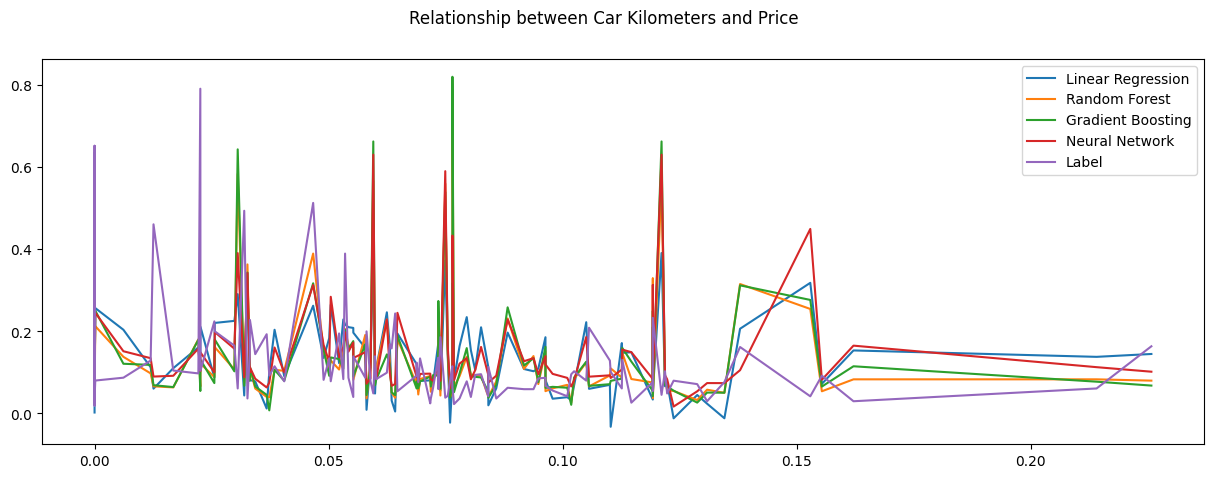

In [224]:
fig, ax = plt.subplots(figsize=(15, 5))

fig.suptitle('Relationship between Car Kilometers and Price')

ax.plot(X_test['car_km'], X_test['lin_reg_pred'], label='Linear Regression')
ax.plot(X_test['car_km'], X_test['rf_reg_pred'], label='Random Forest')
ax.plot(X_test['car_km'], X_test['gb_reg_pred'], label='Gradient Boosting')
ax.plot(X_test['car_km'], X_test['nn_reg_pred'], label='Neural Network')
ax.plot(X_test['car_km'], X_test['car_price'], label='Label')

plt.legend()
plt.show()

---

## Referêncais

Data Treatment
- https://pypi.org/project/fancyimpute/#description

Regression Models
- [Linear Regression] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- [Random Forest Regressor] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- [Gradient Boosting Regressor] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
- [Neural Network Rsgressor] https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

Further Reading
- https://keras.io/examples/keras_recipes/reproducibility_recipes/

Automated Optimization
- [Optuna - A hyperparameter optimization framework] https://optuna.org/
- https://automl.github.io/auto-sklearn/master/index.html

Didactic Material
- https://towardsdatascience.com/7-of-the-most-commonly-used-regression-algorithms-and-how-to-choose-the-right-one-fc3c8890f9e3